In [5]:
import os
import random

from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, mean_squared_error
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD


RANDOM_STATE=0
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

drive.mount("/content/drive")
# os.chdir("/content/drive/MyDrive/courses/masters/winter 24/ece 219/project 3")
os.chdir("/content/drive/MyDrive/ece 219/project 3")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162996 sha256=e10e3fa3460070b8f33c9be10a1223e179f8ab7f7f6119623309f8731c5fb9fb
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


# Pre-processing

In [ ]:
ratings_raw = pd.read_csv("movie dataset/ratings.csv", usecols=["userId", "movieId", "rating", "timestamp"])

In [ ]:
print (ratings_raw.head())

print (f"Total entries: {len(ratings_raw)}")
print (f"Total users: {len(set(ratings_raw['userId']))}")
print (f"Minimum userId: {min(ratings_raw['userId'])}")
print (f"Maximum userId: {max(ratings_raw['userId'])}")
print (f"Total movies: {len(set(ratings_raw['movieId']))}")
print (f"Minimum movieId: {min(ratings_raw['movieId'])}")
print (f"Maximum movieId: {max(ratings_raw['movieId'])}")

   userId  movieId  rating   timestamp
0     496   112852     3.0  1415520462
1     391     1947     4.0  1030945141
2     387     1562     1.5  1095041022
3     474     2716     4.5  1053020930
4     483    88125     4.5  1311337237
Total entries: 100836
Total users: 610
Minimum userId: 1
Maximum userId: 610
Total movies: 9724
Minimum movieId: 1
Maximum movieId: 193609


# Exploring Dataset

In [ ]:
movie_ids = ratings_raw["movieId"]
number_movies = len(set(movie_ids))

user_ids = ratings_raw["userId"]
number_users = len(set(user_ids))

sparsity = len(ratings_raw) / (number_movies * number_users)
print (f"Sparsity: {sparsity}")

Sparsity: 0.016999683055613623


Counter({4.0: 26816, 3.0: 20046, 5.0: 13211, 3.5: 13136, 4.5: 8553, 2.0: 7551, 2.5: 5551, 1.0: 2811, 1.5: 1791, 0.5: 1370})
Minimum rating: 0.5
Maximum rating: 5.0


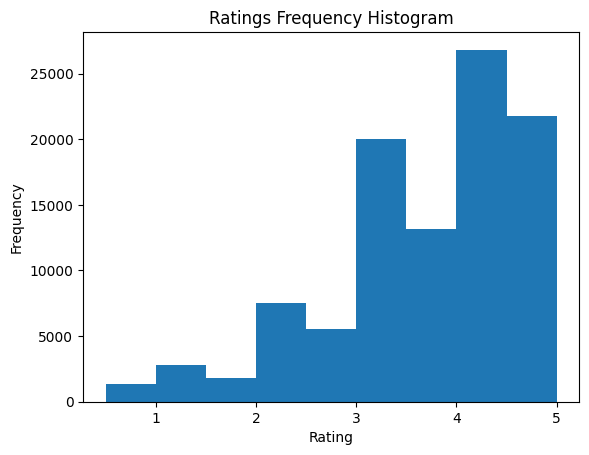

In [ ]:
ratings = ratings_raw["rating"]
ratings_counter = Counter(ratings)

print (ratings_counter)

min_rating = min(ratings)
max_rating = max(ratings)

print (f"Minimum rating: {min_rating}")
print (f"Maximum rating: {max_rating}")

num_bins = int((max_rating - min_rating) // 0.5)
plt.hist(ratings, bins=num_bins)
plt.title("Ratings Frequency Histogram")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

Counter({356: 329, 318: 317, 296: 307, 593: 279, 2571: 278, 260: 251, 480: 238, 110: 237, 589: 224, 527: 220, 2959: 218, 1: 215, 1196: 211, 2858: 204, 50: 204, 47: 203, 780: 202, 150: 201, 1198: 200, 4993: 198, 1210: 196, 858: 192, 457: 190, 592: 189, 2028: 188, 5952: 188, 7153: 185, 588: 183, 608: 181, 2762: 179, 380: 178, 32: 177, 364: 172, 1270: 171, 377: 171, 3578: 170, 4306: 170, 1580: 165, 590: 164, 648: 162, 344: 161, 4226: 159, 367: 157, 6539: 149, 58559: 149, 595: 146, 1214: 146, 1036: 145, 500: 144, 165: 144, 1265: 143, 79132: 143, 1197: 142, 1704: 141, 6377: 141, 1291: 140, 1721: 140, 316: 140, 2628: 140, 153: 137, 1136: 136, 597: 135, 231: 133, 293: 133, 1193: 133, 3793: 133, 10: 132, 4886: 132, 1089: 131, 7361: 131, 1240: 131, 6874: 131, 1221: 129, 2329: 129, 34: 128, 1213: 126, 1200: 126, 8961: 125, 1682: 125, 541: 124, 736: 123, 4995: 123, 5349: 122, 1097: 122, 733: 121, 2683: 121, 2716: 120, 4973: 120, 1206: 120, 5445: 120, 4963: 119, 1073: 119, 1527: 116, 33794: 116, 5

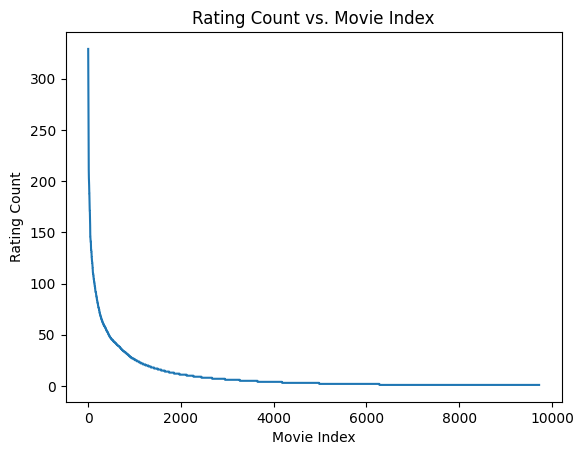

In [ ]:
movie_id_counter = Counter(movie_ids)

print (movie_id_counter)

plt.plot(range(1, number_movies+1), sorted(movie_id_counter.values(), reverse=True))
plt.title("Rating Count vs. Movie Index")
plt.xlabel("Movie Index")
plt.ylabel("Rating Count")
plt.show()

Counter({414: 2698, 599: 2478, 474: 2108, 448: 1864, 274: 1346, 610: 1302, 68: 1260, 380: 1218, 606: 1115, 288: 1055, 249: 1046, 387: 1027, 182: 977, 307: 975, 603: 943, 298: 939, 177: 904, 318: 879, 232: 862, 480: 836, 608: 831, 600: 763, 483: 728, 590: 728, 105: 722, 19: 703, 305: 677, 489: 648, 111: 646, 438: 635, 217: 613, 140: 608, 477: 600, 555: 578, 91: 575, 28: 570, 219: 528, 534: 520, 89: 518, 64: 517, 226: 507, 561: 505, 18: 502, 525: 500, 57: 476, 381: 474, 368: 469, 509: 467, 469: 465, 560: 458, 462: 455, 292: 446, 21: 443, 597: 443, 42: 440, 160: 437, 294: 437, 580: 436, 596: 411, 202: 403, 275: 403, 517: 400, 45: 399, 156: 398, 514: 397, 391: 386, 567: 385, 357: 383, 103: 377, 339: 371, 62: 366, 199: 363, 125: 360, 51: 359, 132: 347, 66: 345, 313: 340, 200: 334, 221: 331, 6: 314, 453: 311, 50: 310, 425: 306, 428: 300, 573: 299, 352: 294, 84: 293, 122: 292, 382: 291, 356: 289, 239: 279, 135: 279, 365: 277, 484: 275, 104: 273, 63: 271, 325: 270, 169: 269, 290: 267, 332: 267

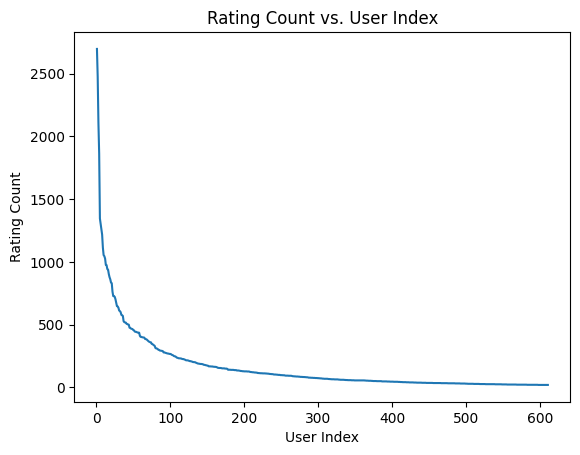

In [ ]:
user_id_counter = Counter(user_ids)

print (user_id_counter)

plt.plot(range(1, number_users+1), sorted(user_id_counter.values(), reverse=True))
plt.title("Rating Count vs. User Index")
plt.xlabel("User Index")
plt.ylabel("Rating Count")
plt.show()

Minimum variance: 0.0
Maximum variance: 5.0625


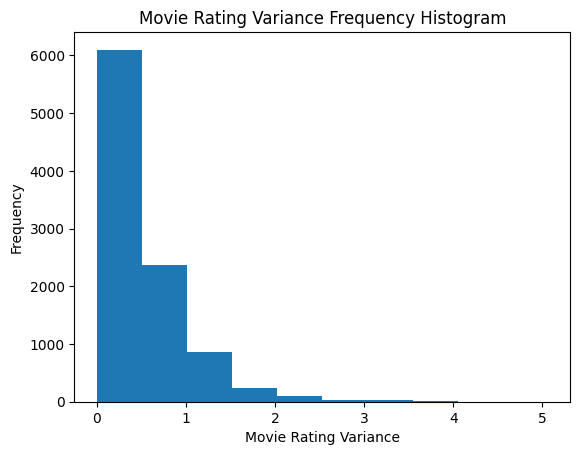

In [ ]:
movies = list(movie_id_counter.keys())

movie_rating_variances = []
movie_id_to_variance = {}
for movie_id in movies:
  movie_id_data = ratings_raw[ratings_raw["movieId"] == movie_id]["rating"]
  movie_variance = np.var(movie_id_data)
  movie_rating_variances.append(movie_variance)
  movie_id_to_variance[movie_id] = movie_variance

min_variance = min(movie_rating_variances)
max_variance = max(movie_rating_variances)

print (f"Minimum variance: {min_variance}")
print (f"Maximum variance: {max_variance}")

num_bins = int((max_variance - min_variance) // 0.5)
plt.hist(movie_rating_variances, bins=num_bins)
plt.title("Movie Rating Variance Frequency Histogram")
plt.xlabel("Movie Rating Variance")
plt.ylabel("Frequency")
plt.show()

# k-NN Collaborative Filter

In [ ]:
"""
Untrimmed data
"""

reader = Reader(rating_scale=(0.5, 5))
ratings_processed = Dataset.load_from_df(ratings_raw[["userId", "movieId", "rating"]], reader=reader)

k_values = [i for i in range(2, 101, 2)]
print (k_values)

avg_rmses = []
avg_maes = []

for k_value in k_values:
  print (f"Running model using k = {k_value}")
  clf = KNNWithMeans(k=k_value, sim_options={"name": "pearson"})
  results = cross_validate(
      clf, ratings_processed, measures=["rmse", "mae"], cv=10)

  avg_rmse = np.mean(results["test_rmse"])
  avg_mae = np.mean(results["test_mae"])

  avg_rmses.append(avg_rmse)
  avg_maes.append(avg_mae)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]
Running model using k = 2
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Runnin

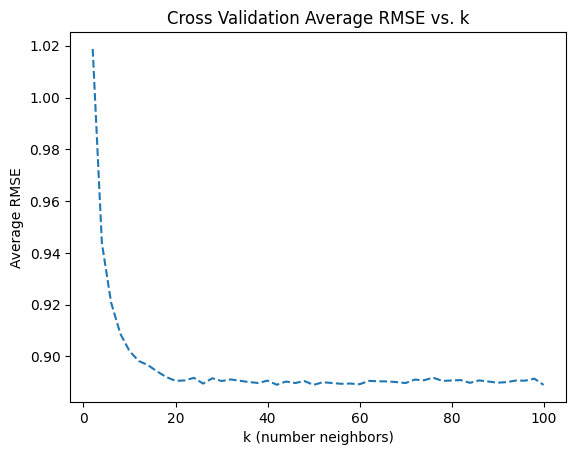

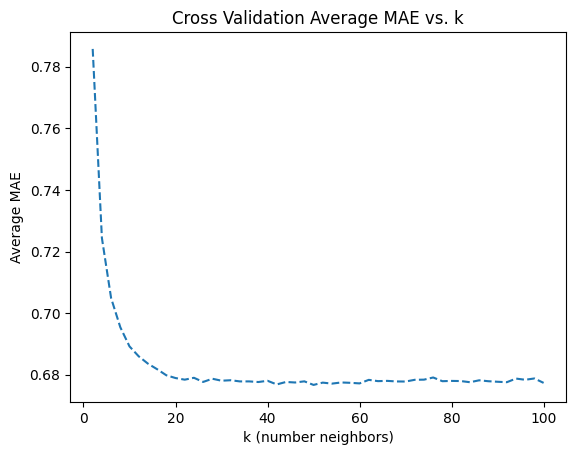

In [ ]:
plt.plot(k_values, avg_rmses, linestyle="--")
plt.title("Cross Validation Average RMSE vs. k")
plt.xlabel("k (number neighbors)")
plt.ylabel("Average RMSE")
plt.show()

plt.plot(k_values, avg_maes, linestyle="--")
plt.title("Cross Validation Average MAE vs. k")
plt.xlabel("k (number neighbors)")
plt.ylabel("Average MAE")
plt.show()

In [ ]:
"""
Popular movie trimming
"""

reader = Reader(rating_scale=(0.5, 5))

# Filter rows where movieId has over two ratings
ratings_popular_movie = ratings_raw[ratings_raw.apply(lambda row: movie_id_counter[row["movieId"]] > 2, axis=1)]
ratings_processed = Dataset.load_from_df(ratings_popular_movie[["userId", "movieId", "rating"]], reader=reader)

k_values = [i for i in range(2, 101, 2)]

avg_rmses = []
avg_maes = []

for k_value in k_values:
  print (f"Running model using k = {k_value}")
  clf = KNNWithMeans(k=k_value, sim_options={"name": "pearson"})
  results = cross_validate(
      clf, ratings_processed, measures=["rmse", "mae"], cv=10)

  avg_rmse = np.mean(results["test_rmse"])
  avg_mae = np.mean(results["test_mae"])

  avg_rmses.append(avg_rmse)
  avg_maes.append(avg_mae)

Running model using k = 2
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Running model using k = 4
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson si

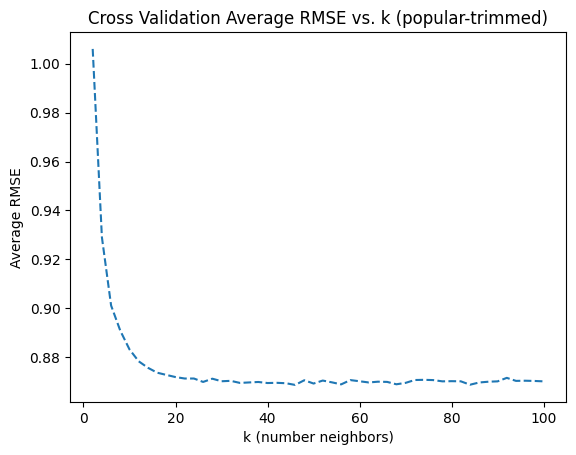

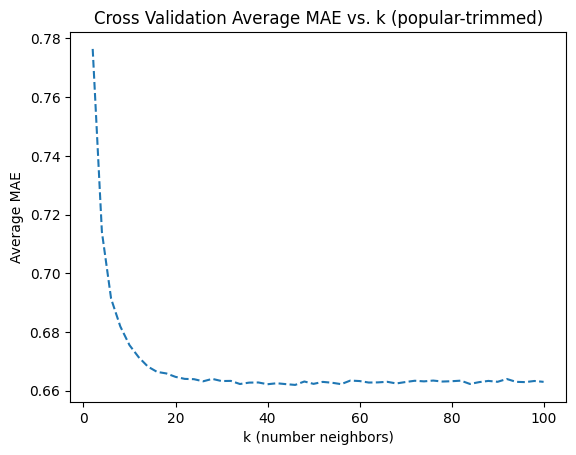

Popular-trimmed: minimum average RMSE -- 0.8687412022803569
Popular-trimmed: minimum average RMSE k -- 46
Popular-trimmed: minimum average MAE -- 0.6619629261904096
Popular-trimmed: minimum average MAE k -- 46


In [ ]:
plt.plot(k_values, avg_rmses, linestyle="--")
plt.title("Cross Validation Average RMSE vs. k (popular-trimmed)")
plt.xlabel("k (number neighbors)")
plt.ylabel("Average RMSE")
plt.show()

plt.plot(k_values, avg_maes, linestyle="--")
plt.title("Cross Validation Average MAE vs. k (popular-trimmed)")
plt.xlabel("k (number neighbors)")
plt.ylabel("Average MAE")
plt.show()

min_avg_rmse = min(avg_rmses)
min_avg_rmse_idx = avg_rmses.index(min_avg_rmse)
min_avg_rmse_k = k_values[min_avg_rmse_idx]

min_avg_mae = min(avg_maes)
min_avg_mae_idx = avg_maes.index(min_avg_mae)
min_avg_mae_k = k_values[min_avg_mae_idx]

print (f"Popular-trimmed: minimum average RMSE -- {min_avg_rmse}")
print (f"Popular-trimmed: minimum average RMSE k -- {min_avg_rmse_k}")

print (f"Popular-trimmed: minimum average MAE -- {min_avg_mae}")
print (f"Popular-trimmed: minimum average MAE k -- {min_avg_mae_k}")

In [ ]:
"""
Unpopular movie trimming
"""

reader = Reader(rating_scale=(0.5, 5))

# Filter rows where movieId has less than or equal to 2 ratings
ratings_unpopular_movie = ratings_raw[ratings_raw.apply(lambda row: movie_id_counter[row["movieId"]] <= 2, axis=1)]
ratings_processed = Dataset.load_from_df(ratings_unpopular_movie[["userId", "movieId", "rating"]], reader=reader)

k_values = [i for i in range(2, 101, 2)]

avg_rmses = []
avg_maes = []

for k_value in k_values:
  print (f"Running model using k = {k_value}")
  clf = KNNWithMeans(k=k_value, sim_options={"name": "pearson"})
  results = cross_validate(
      clf, ratings_processed, measures=["rmse", "mae"], cv=10)

  avg_rmse = np.mean(results["test_rmse"])
  avg_mae = np.mean(results["test_mae"])

  avg_rmses.append(avg_rmse)
  avg_maes.append(avg_mae)

Running model using k = 2
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Running model using k = 4
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson si

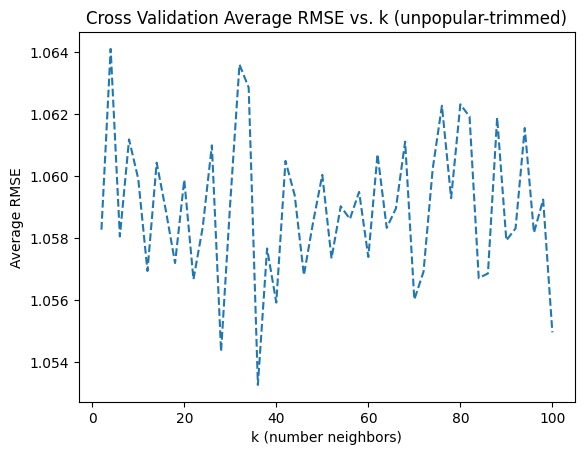

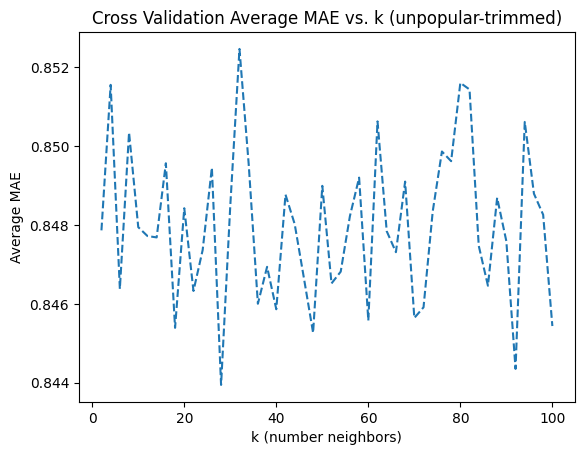

Unpopular-trimmed: minimum average RMSE -- 1.0532709593864114
Unpopular-trimmed: minimum average RMSE k -- 36
Unpopular-trimmed: minimum average MAE -- 0.8439408696818591
Unpopular-trimmed: minimum average MAE k -- 28


In [ ]:
plt.plot(k_values, avg_rmses, linestyle="--")
plt.title("Cross Validation Average RMSE vs. k (unpopular-trimmed)")
plt.xlabel("k (number neighbors)")
plt.ylabel("Average RMSE")
plt.show()

plt.plot(k_values, avg_maes, linestyle="--")
plt.title("Cross Validation Average MAE vs. k (unpopular-trimmed)")
plt.xlabel("k (number neighbors)")
plt.ylabel("Average MAE")
plt.show()

min_avg_rmse = min(avg_rmses)
min_avg_rmse_idx = avg_rmses.index(min_avg_rmse)
min_avg_rmse_k = k_values[min_avg_rmse_idx]

min_avg_mae = min(avg_maes)
min_avg_mae_idx = avg_maes.index(min_avg_mae)
min_avg_mae_k = k_values[min_avg_mae_idx]

print (f"Unpopular-trimmed: minimum average RMSE -- {min_avg_rmse}")
print (f"Unpopular-trimmed: minimum average RMSE k -- {min_avg_rmse_k}")

print (f"Unpopular-trimmed: minimum average MAE -- {min_avg_mae}")
print (f"Unpopular-trimmed: minimum average MAE k -- {min_avg_mae_k}")

In [ ]:
"""
High variance movie trimming
"""

reader = Reader(rating_scale=(0.5, 5))

# Filter rows where movieId has greater than or equal to 2 variance and 5 ratings
ratings_high_variance_movie = ratings_raw[ratings_raw.apply(lambda row: movie_id_to_variance[row["movieId"]] >= 2 and movie_id_counter[row["movieId"]] >= 5, axis=1)]
ratings_processed = Dataset.load_from_df(ratings_high_variance_movie[["userId", "movieId", "rating"]], reader=reader)

k_values = [i for i in range(2, 101, 2)]

avg_rmses = []
avg_maes = []

for k_value in k_values:
  print (f"Running model using k = {k_value}")
  clf = KNNWithMeans(k=k_value, sim_options={"name": "pearson"})
  results = cross_validate(
      clf, ratings_processed, measures=["rmse", "mae"], cv=10)

  avg_rmse = np.mean(results["test_rmse"])
  avg_mae = np.mean(results["test_mae"])

  avg_rmses.append(avg_rmse)
  avg_maes.append(avg_mae)

Running model using k = 2
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Running model using k = 4
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson si

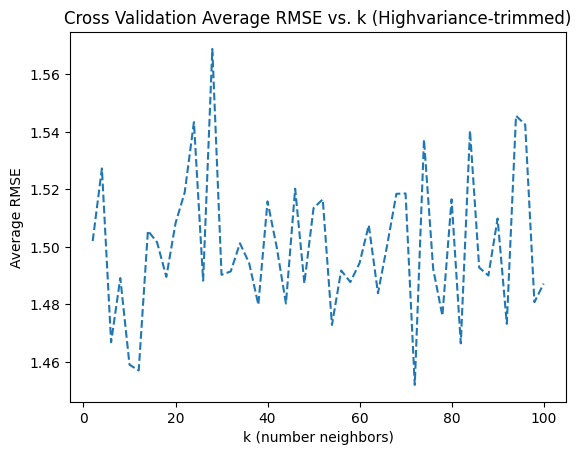

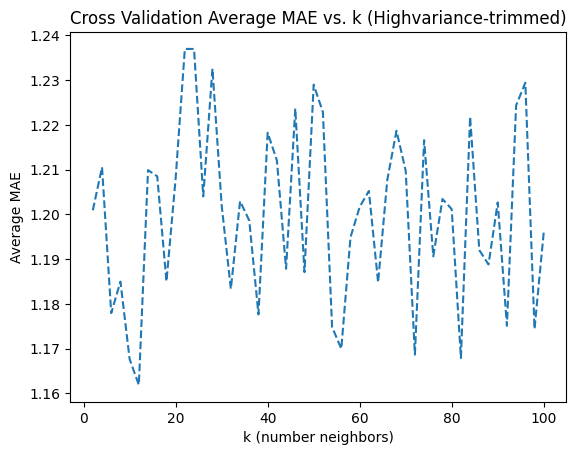

Highvariance-trimmed: minimum average RMSE -- 1.4519969704942841
Highvariance-trimmed: minimum average RMSE k -- 72
Highvariance-trimmed: minimum average MAE -- 1.161883497703054
Highvariance-trimmed: minimum average MAE k -- 12


In [ ]:
plt.plot(k_values, avg_rmses, linestyle="--")
plt.title("Cross Validation Average RMSE vs. k (Highvariance-trimmed)")
plt.xlabel("k (number neighbors)")
plt.ylabel("Average RMSE")
plt.show()

plt.plot(k_values, avg_maes, linestyle="--")
plt.title("Cross Validation Average MAE vs. k (Highvariance-trimmed)")
plt.xlabel("k (number neighbors)")
plt.ylabel("Average MAE")
plt.show()

min_avg_rmse = min(avg_rmses)
min_avg_rmse_idx = avg_rmses.index(min_avg_rmse)
min_avg_rmse_k = k_values[min_avg_rmse_idx]

min_avg_mae = min(avg_maes)
min_avg_mae_idx = avg_maes.index(min_avg_mae)
min_avg_mae_k = k_values[min_avg_mae_idx]

print (f"Highvariance-trimmed: minimum average RMSE -- {min_avg_rmse}")
print (f"Highvariance-trimmed: minimum average RMSE k -- {min_avg_rmse_k}")

print (f"Highvariance-trimmed: minimum average MAE -- {min_avg_mae}")
print (f"Highvariance-trimmed: minimum average MAE k -- {min_avg_mae_k}")

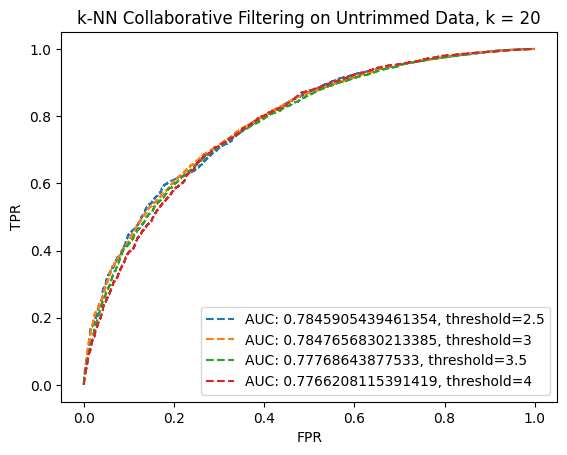

In [ ]:
k = 20
threshold_vals = [2.5, 3, 3.5, 4]

reader = Reader(rating_scale=(0.5, 5))
ratings_processed = Dataset.load_from_df(ratings_raw[["userId", "movieId", "rating"]], reader=reader)

ratings_raw_train, ratings_raw_test = train_test_split(ratings_processed, test_size=0.1)
result = KNNWithMeans(k=k, sim_options={"name": "pearson"}, verbose=False).fit(ratings_raw_train).test(ratings_raw_test)

fig, ax = plt.subplots()
for threshold in threshold_vals:
    actual_binary = []
    for row in result:
        if row.r_ui > threshold:
            actual_binary.append(1)
        else:
            actual_binary.append(0)
    predicted_confidence = [row.est for row in result]
    fpr, tpr, thresholds = roc_curve(actual_binary, predicted_confidence)
    ax.plot(fpr, tpr, linestyle="--", label=f"AUC: {auc(fpr, tpr)}, threshold={threshold}")

plt.legend()
plt.title(f"k-NN Collaborative Filtering on Untrimmed Data, k = {k}")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

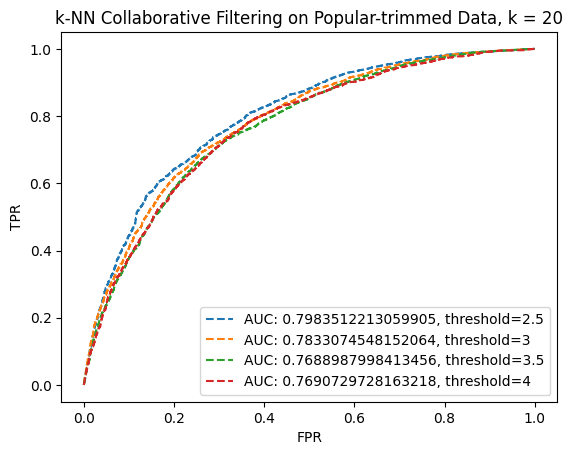

In [ ]:
k = 20
threshold_vals = [2.5, 3, 3.5, 4]

reader = Reader(rating_scale=(0.5, 5))
ratings_processed = Dataset.load_from_df(ratings_popular_movie[["userId", "movieId", "rating"]], reader=reader)

ratings_popular_train, ratings_popular_test = train_test_split(ratings_processed, test_size=0.1)
result = KNNWithMeans(k=k, sim_options={"name": "pearson"}, verbose=False).fit(ratings_popular_train).test(ratings_popular_test)

fig, ax = plt.subplots()
for threshold in threshold_vals:
    actual_binary = []
    for row in result:
        if row.r_ui > threshold:
            actual_binary.append(1)
        else:
            actual_binary.append(0)
    predicted_confidence = [row.est for row in result]
    fpr, tpr, thresholds = roc_curve(actual_binary, predicted_confidence)
    ax.plot(fpr, tpr, linestyle="--", label=f"AUC: {auc(fpr, tpr)}, threshold={threshold}")

plt.legend()
plt.title(f"k-NN Collaborative Filtering on Popular-trimmed Data, k = {k}")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

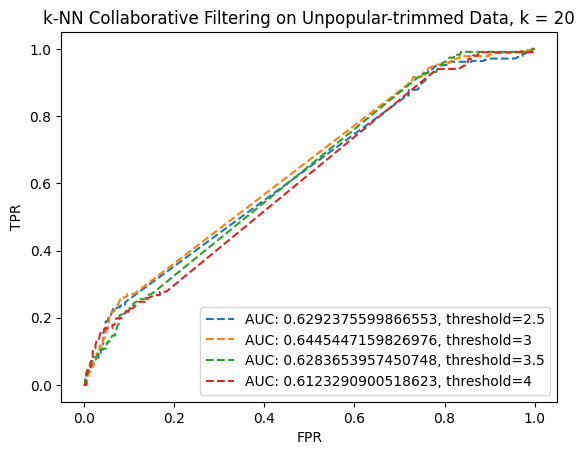

In [ ]:
k = 20
threshold_vals = [2.5, 3, 3.5, 4]

reader = Reader(rating_scale=(0.5, 5))
ratings_processed = Dataset.load_from_df(ratings_unpopular_movie[["userId", "movieId", "rating"]], reader=reader)

ratings_unpopular_train, ratings_unpopular_test = train_test_split(ratings_processed, test_size=0.1)
result = KNNWithMeans(k=k, sim_options={"name": "pearson"}, verbose=False).fit(ratings_unpopular_train).test(ratings_unpopular_test)

fig, ax = plt.subplots()
for threshold in threshold_vals:
    actual_binary = []
    for row in result:
        if row.r_ui > threshold:
            actual_binary.append(1)
        else:
            actual_binary.append(0)
    predicted_confidence = [row.est for row in result]
    fpr, tpr, thresholds = roc_curve(actual_binary, predicted_confidence)
    ax.plot(fpr, tpr, linestyle="--", label=f"AUC: {auc(fpr, tpr)}, threshold={threshold}")

plt.legend()
plt.title(f"k-NN Collaborative Filtering on Unpopular-trimmed Data, k = {k}")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

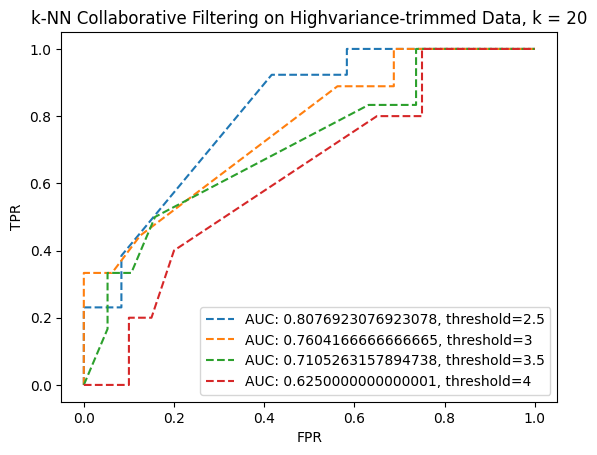

In [ ]:
k = 20
threshold_vals = [2.5, 3, 3.5, 4]

reader = Reader(rating_scale=(0.5, 5))
ratings_processed = Dataset.load_from_df(ratings_high_variance_movie[["userId", "movieId", "rating"]], reader=reader)

ratings_high_variance_train, ratings_high_variance_test = train_test_split(ratings_processed, test_size=0.1)
result = KNNWithMeans(k=k, sim_options={"name": "pearson"}, verbose=False).fit(ratings_high_variance_train).test(ratings_high_variance_test)

fig, ax = plt.subplots()
for threshold in threshold_vals:
    actual_binary = []
    for row in result:
        if row.r_ui > threshold:
            actual_binary.append(1)
        else:
            actual_binary.append(0)
    predicted_confidence = [row.est for row in result]
    fpr, tpr, thresholds = roc_curve(actual_binary, predicted_confidence)
    ax.plot(fpr, tpr, linestyle="--", label=f"AUC: {auc(fpr, tpr)}, threshold={threshold}")

plt.legend()
plt.title(f"k-NN Collaborative Filtering on Highvariance-trimmed Data, k = {k}")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

# NMF Collaborative Filter

In [ ]:
reader = Reader(rating_scale=(0.5, 5))
ratings_processed = Dataset.load_from_df(ratings_raw[["userId", "movieId", "rating"]], reader=reader)

k_values = [i for i in range(2, 51, 4)]
print (k_values)

avg_rmses = []
avg_maes = []

for k_value in k_values:
  print (f"Running NMF model (untrimmed) using k = {k_value}")
  clf = NMF(n_factors=k_value, n_epochs=50, verbose=False)
  results = cross_validate(
      clf, ratings_processed, measures=["rmse", "mae"], cv=10)

  avg_rmse = np.mean(results["test_rmse"])
  avg_mae = np.mean(results["test_mae"])

  avg_rmses.append(avg_rmse)
  avg_maes.append(avg_mae)

[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50]
Running NMF model (untrimmed) using k = 2
Running NMF model (untrimmed) using k = 6
Running NMF model (untrimmed) using k = 10
Running NMF model (untrimmed) using k = 14
Running NMF model (untrimmed) using k = 18
Running NMF model (untrimmed) using k = 22
Running NMF model (untrimmed) using k = 26
Running NMF model (untrimmed) using k = 30
Running NMF model (untrimmed) using k = 34
Running NMF model (untrimmed) using k = 38
Running NMF model (untrimmed) using k = 42
Running NMF model (untrimmed) using k = 46
Running NMF model (untrimmed) using k = 50


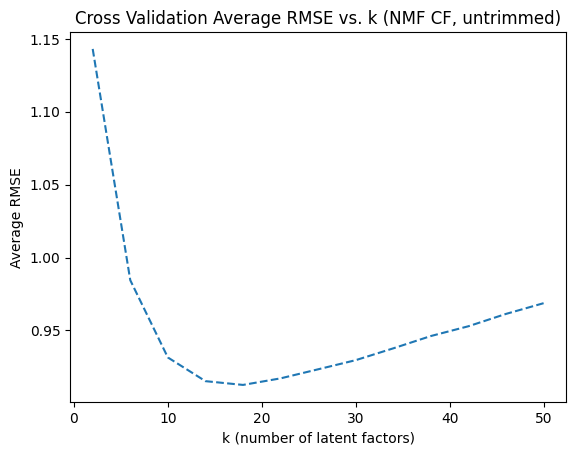

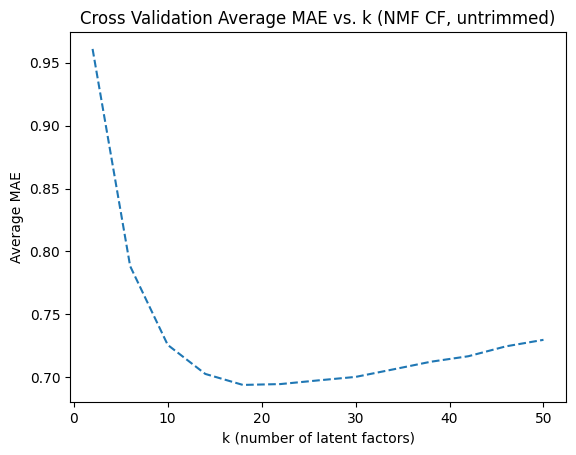

NMF CF, untrimmed: minimum average RMSE -- 0.9126408848471351
NMF CF, untrimmed: minimum average RMSE k -- 18
NMF CF, untrimmed: minimum average MAE -- 0.6939760785175113
NMF CF, untrimmed: minimum average MAE k -- 18


In [ ]:
plt.plot(k_values, avg_rmses, linestyle="--")
plt.title("Cross Validation Average RMSE vs. k (NMF CF, untrimmed)")
plt.xlabel("k (number of latent factors)")
plt.ylabel("Average RMSE")
plt.show()

plt.plot(k_values, avg_maes, linestyle="--")
plt.title("Cross Validation Average MAE vs. k (NMF CF, untrimmed)")
plt.xlabel("k (number of latent factors)")
plt.ylabel("Average MAE")
plt.show()

min_avg_rmse = min(avg_rmses)
min_avg_rmse_idx = avg_rmses.index(min_avg_rmse)
min_avg_rmse_k = k_values[min_avg_rmse_idx]

min_avg_mae = min(avg_maes)
min_avg_mae_idx = avg_maes.index(min_avg_mae)
min_avg_mae_k = k_values[min_avg_mae_idx]

print (f"NMF CF, untrimmed: minimum average RMSE -- {min_avg_rmse}")
print (f"NMF CF, untrimmed: minimum average RMSE k -- {min_avg_rmse_k}")

print (f"NMF CF, untrimmed: minimum average MAE -- {min_avg_mae}")
print (f"NMF CF, untrimmed: minimum average MAE k -- {min_avg_mae_k}")

In [ ]:
reader = Reader(rating_scale=(0.5, 5))
ratings_processed = Dataset.load_from_df(ratings_popular_movie[["userId", "movieId", "rating"]], reader=reader)

k_values = [i for i in range(2, 51, 4)]
print (k_values)

avg_rmses = []
avg_maes = []

for k_value in k_values:
  print (f"Running NMF model (popular-trimmed) using k = {k_value}")
  clf = NMF(n_factors=k_value, n_epochs=50, verbose=False)
  results = cross_validate(
      clf, ratings_processed, measures=["rmse", "mae"], cv=10)

  avg_rmse = np.mean(results["test_rmse"])
  avg_mae = np.mean(results["test_mae"])

  avg_rmses.append(avg_rmse)
  avg_maes.append(avg_mae)

[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50]
Running NMF model (popular-trimmed) using k = 2
Running NMF model (popular-trimmed) using k = 6
Running NMF model (popular-trimmed) using k = 10
Running NMF model (popular-trimmed) using k = 14
Running NMF model (popular-trimmed) using k = 18
Running NMF model (popular-trimmed) using k = 22
Running NMF model (popular-trimmed) using k = 26
Running NMF model (popular-trimmed) using k = 30
Running NMF model (popular-trimmed) using k = 34
Running NMF model (popular-trimmed) using k = 38
Running NMF model (popular-trimmed) using k = 42
Running NMF model (popular-trimmed) using k = 46
Running NMF model (popular-trimmed) using k = 50


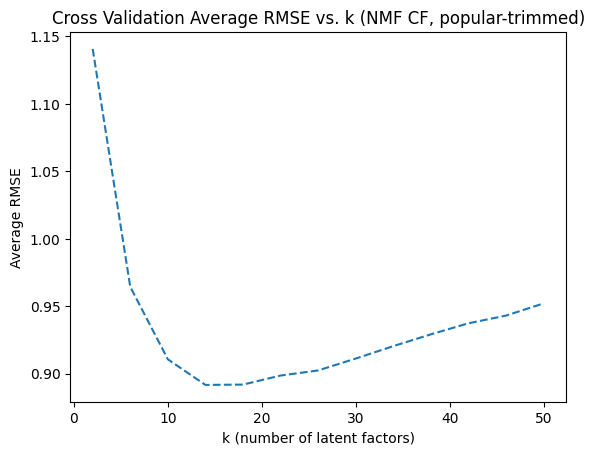

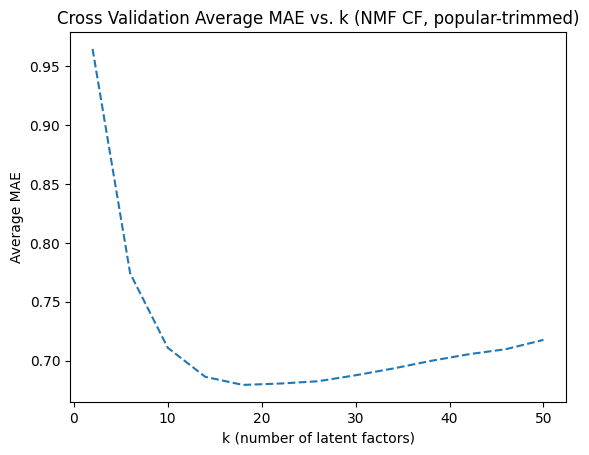

NMF CF, popular-trimmed: minimum average RMSE -- 0.8917246435074692
NMF CF, popular-trimmed: minimum average RMSE k -- 14
NMF CF, popular-trimmed: minimum average MAE -- 0.6792902526970149
NMF CF, popular-trimmed: minimum average MAE k -- 18


In [ ]:
plt.plot(k_values, avg_rmses, linestyle="--")
plt.title("Cross Validation Average RMSE vs. k (NMF CF, popular-trimmed)")
plt.xlabel("k (number of latent factors)")
plt.ylabel("Average RMSE")
plt.show()

plt.plot(k_values, avg_maes, linestyle="--")
plt.title("Cross Validation Average MAE vs. k (NMF CF, popular-trimmed)")
plt.xlabel("k (number of latent factors)")
plt.ylabel("Average MAE")
plt.show()

min_avg_rmse = min(avg_rmses)
min_avg_rmse_idx = avg_rmses.index(min_avg_rmse)
min_avg_rmse_k = k_values[min_avg_rmse_idx]

min_avg_mae = min(avg_maes)
min_avg_mae_idx = avg_maes.index(min_avg_mae)
min_avg_mae_k = k_values[min_avg_mae_idx]

print (f"NMF CF, popular-trimmed: minimum average RMSE -- {min_avg_rmse}")
print (f"NMF CF, popular-trimmed: minimum average RMSE k -- {min_avg_rmse_k}")

print (f"NMF CF, popular-trimmed: minimum average MAE -- {min_avg_mae}")
print (f"NMF CF, popular-trimmed: minimum average MAE k -- {min_avg_mae_k}")

In [ ]:
reader = Reader(rating_scale=(0.5, 5))
ratings_processed = Dataset.load_from_df(ratings_unpopular_movie[["userId", "movieId", "rating"]], reader=reader)

k_values = [i for i in range(2, 51, 4)]
print (k_values)

avg_rmses = []
avg_maes = []

for k_value in k_values:
  print (f"Running NMF model (unpopular-trimmed) using k = {k_value}")
  clf = NMF(n_factors=k_value, n_epochs=50, verbose=False)
  results = cross_validate(
      clf, ratings_processed, measures=["rmse", "mae"], cv=10)

  avg_rmse = np.mean(results["test_rmse"])
  avg_mae = np.mean(results["test_mae"])

  avg_rmses.append(avg_rmse)
  avg_maes.append(avg_mae)

[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50]
Running NMF model (unpopular-trimmed) using k = 2
Running NMF model (unpopular-trimmed) using k = 6
Running NMF model (unpopular-trimmed) using k = 10
Running NMF model (unpopular-trimmed) using k = 14
Running NMF model (unpopular-trimmed) using k = 18
Running NMF model (unpopular-trimmed) using k = 22
Running NMF model (unpopular-trimmed) using k = 26
Running NMF model (unpopular-trimmed) using k = 30
Running NMF model (unpopular-trimmed) using k = 34
Running NMF model (unpopular-trimmed) using k = 38
Running NMF model (unpopular-trimmed) using k = 42
Running NMF model (unpopular-trimmed) using k = 46
Running NMF model (unpopular-trimmed) using k = 50


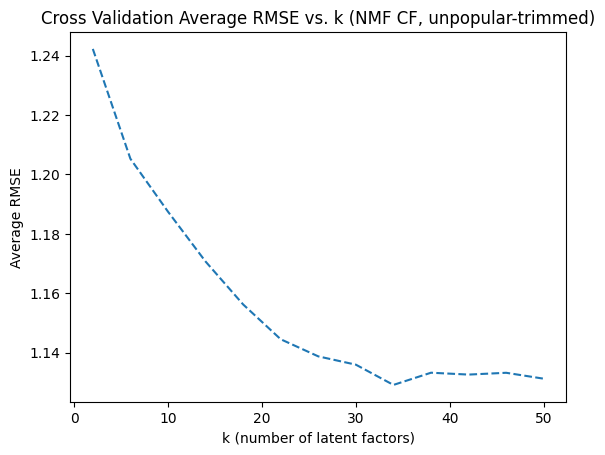

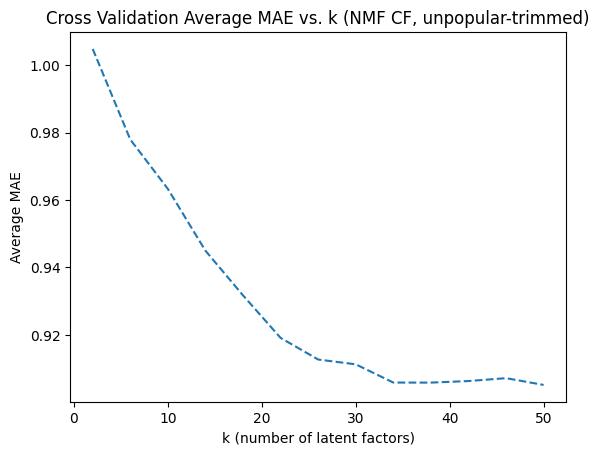

NMF CF, unpopular-trimmed: minimum average RMSE -- 1.1291450365092746
NMF CF, unpopular-trimmed: minimum average RMSE k -- 34
NMF CF, unpopular-trimmed: minimum average MAE -- 0.9051719805143954
NMF CF, unpopular-trimmed: minimum average MAE k -- 50


In [ ]:
plt.plot(k_values, avg_rmses, linestyle="--")
plt.title("Cross Validation Average RMSE vs. k (NMF CF, unpopular-trimmed)")
plt.xlabel("k (number of latent factors)")
plt.ylabel("Average RMSE")
plt.show()

plt.plot(k_values, avg_maes, linestyle="--")
plt.title("Cross Validation Average MAE vs. k (NMF CF, unpopular-trimmed)")
plt.xlabel("k (number of latent factors)")
plt.ylabel("Average MAE")
plt.show()

min_avg_rmse = min(avg_rmses)
min_avg_rmse_idx = avg_rmses.index(min_avg_rmse)
min_avg_rmse_k = k_values[min_avg_rmse_idx]

min_avg_mae = min(avg_maes)
min_avg_mae_idx = avg_maes.index(min_avg_mae)
min_avg_mae_k = k_values[min_avg_mae_idx]

print (f"NMF CF, unpopular-trimmed: minimum average RMSE -- {min_avg_rmse}")
print (f"NMF CF, unpopular-trimmed: minimum average RMSE k -- {min_avg_rmse_k}")

print (f"NMF CF, unpopular-trimmed: minimum average MAE -- {min_avg_mae}")
print (f"NMF CF, unpopular-trimmed: minimum average MAE k -- {min_avg_mae_k}")

In [ ]:
reader = Reader(rating_scale=(0.5, 5))
ratings_processed = Dataset.load_from_df(ratings_high_variance_movie[["userId", "movieId", "rating"]], reader=reader)

k_values = [i for i in range(2, 51, 4)]
print (k_values)

avg_rmses = []
avg_maes = []

for k_value in k_values:
  print (f"Running NMF model (highvariance-trimmed) using k = {k_value}")
  clf = NMF(n_factors=k_value, n_epochs=50, verbose=False)
  results = cross_validate(
      clf, ratings_processed, measures=["rmse", "mae"], cv=10)

  avg_rmse = np.mean(results["test_rmse"])
  avg_mae = np.mean(results["test_mae"])

  avg_rmses.append(avg_rmse)
  avg_maes.append(avg_mae)

[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50]
Running NMF model (highvariance-trimmed) using k = 2
Running NMF model (highvariance-trimmed) using k = 6
Running NMF model (highvariance-trimmed) using k = 10
Running NMF model (highvariance-trimmed) using k = 14
Running NMF model (highvariance-trimmed) using k = 18
Running NMF model (highvariance-trimmed) using k = 22
Running NMF model (highvariance-trimmed) using k = 26
Running NMF model (highvariance-trimmed) using k = 30
Running NMF model (highvariance-trimmed) using k = 34
Running NMF model (highvariance-trimmed) using k = 38
Running NMF model (highvariance-trimmed) using k = 42
Running NMF model (highvariance-trimmed) using k = 46
Running NMF model (highvariance-trimmed) using k = 50


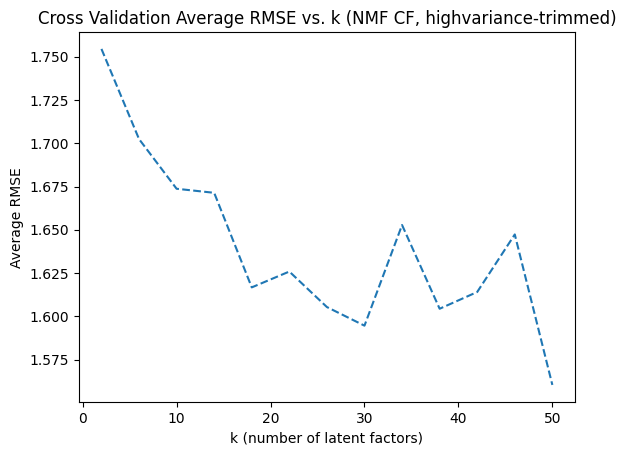

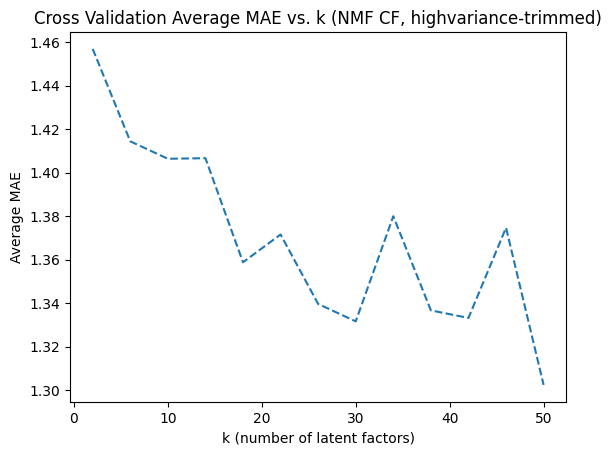

NMF CF, highvariance-trimmed: minimum average RMSE -- 1.560312178741119
NMF CF, highvariance-trimmed: minimum average RMSE k -- 50
NMF CF, highvariance-trimmed: minimum average MAE -- 1.3024488202678068
NMF CF, highvariance-trimmed: minimum average MAE k -- 50


In [ ]:
plt.plot(k_values, avg_rmses, linestyle="--")
plt.title("Cross Validation Average RMSE vs. k (NMF CF, highvariance-trimmed)")
plt.xlabel("k (number of latent factors)")
plt.ylabel("Average RMSE")
plt.show()

plt.plot(k_values, avg_maes, linestyle="--")
plt.title("Cross Validation Average MAE vs. k (NMF CF, highvariance-trimmed)")
plt.xlabel("k (number of latent factors)")
plt.ylabel("Average MAE")
plt.show()

min_avg_rmse = min(avg_rmses)
min_avg_rmse_idx = avg_rmses.index(min_avg_rmse)
min_avg_rmse_k = k_values[min_avg_rmse_idx]

min_avg_mae = min(avg_maes)
min_avg_mae_idx = avg_maes.index(min_avg_mae)
min_avg_mae_k = k_values[min_avg_mae_idx]

print (f"NMF CF, highvariance-trimmed: minimum average RMSE -- {min_avg_rmse}")
print (f"NMF CF, highvariance-trimmed: minimum average RMSE k -- {min_avg_rmse_k}")

print (f"NMF CF, highvariance-trimmed: minimum average MAE -- {min_avg_mae}")
print (f"NMF CF, highvariance-trimmed: minimum average MAE k -- {min_avg_mae_k}")

In [ ]:
genres_data = pd.read_csv("movie dataset/movies.csv")
print (genres_data.head())

all_genres = set()
genres = genres_data["genres"]
for row in genres:
  row_genres = row.split("|")
  for genre in row_genres:
    if genre != "(no genres listed)":
      all_genres.add(genre)

print (all_genres)
print (f"Total number of genres: {len(all_genres)}")

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
{'Action', 'Horror', 'Children', 'Romance', 'IMAX', 'Animation', 'Mystery', 'Documentary', 'Comedy', 'Fantasy', 'War', 'Sci-Fi', 'Crime', 'Film-Noir', 'Thriller', 'Adventure', 'Drama', 'Musical', 'Western'}
Total number of genres: 19


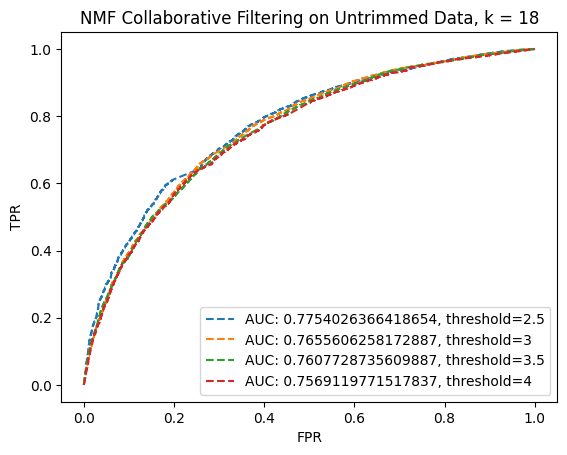

In [ ]:
k = 18
threshold_vals = [2.5, 3, 3.5, 4]

reader = Reader(rating_scale=(0.5, 5))
ratings_processed = Dataset.load_from_df(ratings_raw[["userId", "movieId", "rating"]], reader=reader)

ratings_raw_train, ratings_raw_test = train_test_split(ratings_processed, test_size=0.1)
result = NMF(n_factors=k, n_epochs=50, verbose=False).fit(ratings_raw_train).test(ratings_raw_test)

fig, ax = plt.subplots()
for threshold in threshold_vals:
    actual_binary = []
    for row in result:
        if row.r_ui > threshold:
            actual_binary.append(1)
        else:
            actual_binary.append(0)
    predicted_confidence = [row.est for row in result]
    fpr, tpr, thresholds = roc_curve(actual_binary, predicted_confidence)
    ax.plot(fpr, tpr, linestyle="--", label=f"AUC: {auc(fpr, tpr)}, threshold={threshold}")

plt.legend()
plt.title(f"NMF Collaborative Filtering on Untrimmed Data, k = {k}")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

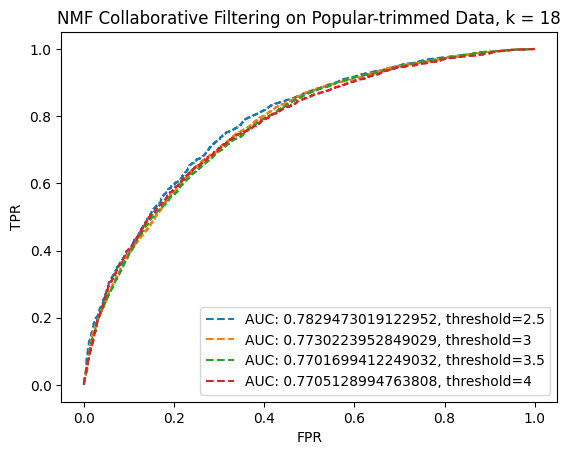

In [ ]:
k = 18
threshold_vals = [2.5, 3, 3.5, 4]

reader = Reader(rating_scale=(0.5, 5))
ratings_processed = Dataset.load_from_df(ratings_popular_movie[["userId", "movieId", "rating"]], reader=reader)

ratings_popular_train, ratings_popular_test = train_test_split(ratings_processed, test_size=0.1)
result = NMF(n_factors=k, n_epochs=50, verbose=False).fit(ratings_popular_train).test(ratings_popular_test)

fig, ax = plt.subplots()
for threshold in threshold_vals:
    actual_binary = []
    for row in result:
        if row.r_ui > threshold:
            actual_binary.append(1)
        else:
            actual_binary.append(0)
    predicted_confidence = [row.est for row in result]
    fpr, tpr, thresholds = roc_curve(actual_binary, predicted_confidence)
    ax.plot(fpr, tpr, linestyle="--", label=f"AUC: {auc(fpr, tpr)}, threshold={threshold}")

plt.legend()
plt.title(f"NMF Collaborative Filtering on Popular-trimmed Data, k = {k}")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

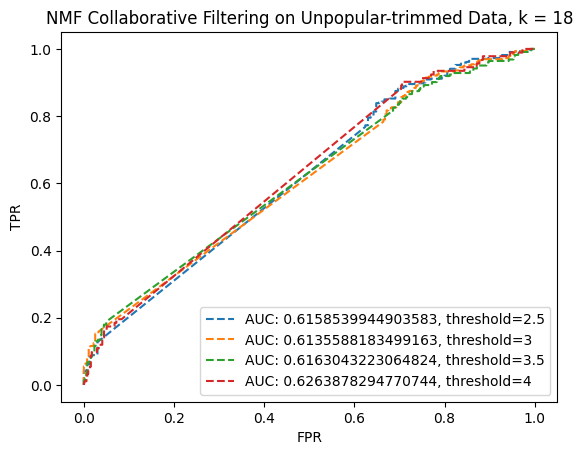

In [ ]:
k = 18
threshold_vals = [2.5, 3, 3.5, 4]

reader = Reader(rating_scale=(0.5, 5))
ratings_processed = Dataset.load_from_df(ratings_unpopular_movie[["userId", "movieId", "rating"]], reader=reader)

ratings_unpopular_train, ratings_unpopular_test = train_test_split(ratings_processed, test_size=0.1)
result = NMF(n_factors=k, n_epochs=50, verbose=False).fit(ratings_unpopular_train).test(ratings_unpopular_test)

fig, ax = plt.subplots()
for threshold in threshold_vals:
    actual_binary = []
    for row in result:
        if row.r_ui > threshold:
            actual_binary.append(1)
        else:
            actual_binary.append(0)
    predicted_confidence = [row.est for row in result]
    fpr, tpr, thresholds = roc_curve(actual_binary, predicted_confidence)
    ax.plot(fpr, tpr, linestyle="--", label=f"AUC: {auc(fpr, tpr)}, threshold={threshold}")

plt.legend()
plt.title(f"NMF Collaborative Filtering on Unpopular-trimmed Data, k = {k}")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

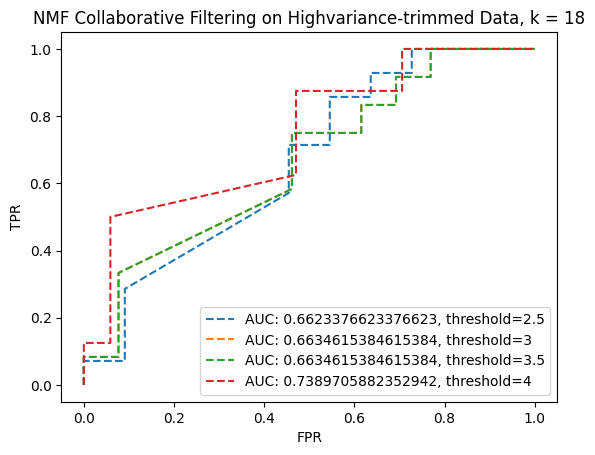

In [ ]:
k = 18
threshold_vals = [2.5, 3, 3.5, 4]

reader = Reader(rating_scale=(0.5, 5))
ratings_processed = Dataset.load_from_df(ratings_high_variance_movie[["userId", "movieId", "rating"]], reader=reader)

ratings_high_variance_train, ratings_high_variance_test = train_test_split(ratings_processed, test_size=0.1)
result = NMF(n_factors=k, n_epochs=50, verbose=False).fit(ratings_high_variance_train).test(ratings_high_variance_test)

fig, ax = plt.subplots()
for threshold in threshold_vals:
    actual_binary = []
    for row in result:
        if row.r_ui > threshold:
            actual_binary.append(1)
        else:
            actual_binary.append(0)
    predicted_confidence = [row.est for row in result]
    fpr, tpr, thresholds = roc_curve(actual_binary, predicted_confidence)
    ax.plot(fpr, tpr, linestyle="--", label=f"AUC: {auc(fpr, tpr)}, threshold={threshold}")

plt.legend()
plt.title(f"NMF Collaborative Filtering on Highvariance-trimmed Data, k = {k}")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [ ]:
reader = Reader(rating_scale=(0.5, 5))
ratings_processed = Dataset.load_from_df(ratings_raw[["userId", "movieId", "rating"]], reader=reader)
ratings_raw_train, ratings_raw_test = train_test_split(ratings_processed, test_size=0.1)

nmf = NMF(n_factors=20, n_epochs=50, verbose=False)
nmf.fit(ratings_raw_train).test(ratings_raw_test)
U, V = nmf.pu, nmf.qi

print (f"U shape: {U.shape}")
print (f"V shape: {V.shape}")

# Iterate through movie-latent factors
for col_idx in range(V.shape[1]):
    print (f"Processing column {col_idx}")
    V_col = V[:, col_idx]
    V_col_sorted_idx = np.argsort(V_col)[::-1]

    # Iterate through top 10 movies for each factor and get corresponding genre
    for movie_idx in V_col_sorted_idx[:10]:
        print (genres_data["genres"][movie_idx])

    print ("\n\n")

U shape: (610, 20)
V shape: (9359, 20)
Processing column 0
Action|Drama|Sci-Fi
Drama
Comedy|Mystery|Thriller
Adventure|Comedy|Drama|Romance
Comedy|Drama|Romance
Documentary
Comedy|Drama
Comedy|War
Drama|Mystery
Comedy



Processing column 1
Action|Crime|Thriller
Drama|Romance
Action|Adventure|Fantasy|IMAX
Action|Comedy|Fantasy|Horror|Thriller
Adventure|Drama|Romance
Drama
Comedy|Drama
Drama|War
Documentary
Drama



Processing column 2
Comedy
Action|Drama|Thriller
Comedy|Drama|Romance
Drama
Comedy|Drama
Documentary
Comedy|Romance
Action|Adventure|Fantasy
Comedy
Comedy|Drama|Romance



Processing column 3
Drama|Romance
Crime|Drama
Documentary|War
Sci-Fi|Thriller
Horror|Thriller
Horror
Comedy|Mystery|Thriller
Horror
Drama|Romance
Drama



Processing column 4
Action|Horror|Sci-Fi|Thriller
Action|Comedy
Animation|Children|Comedy
Drama
Comedy
Action|Adventure|Sci-Fi
Drama
Action|Drama
Drama|Horror|Thriller
Adventure|Comedy



Processing column 5
Crime|Drama|Thriller
Documentary
Drama
Drama|H

In [ ]:
print (V[0][0])

0.3194081063617428


## MF Collaborative Filter

In [ ]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import cross_validate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

reader = Reader(rating_scale=(0.5, 5))
ratings_processed = Dataset.load_from_df(ratings_raw[["userId", "movieId", "rating"]], reader=reader)

k_values = range(2, 51, 2)
average_rmse = []
average_mae = []

for k in k_values:
    algo = SVD(n_factors=k)
    results = cross_validate(algo, ratings_processed, measures=['RMSE', 'MAE'], cv=10, verbose=False)

    average_rmse.append(np.mean(results['test_rmse']))
    average_mae.append(np.mean(results['test_mae']))

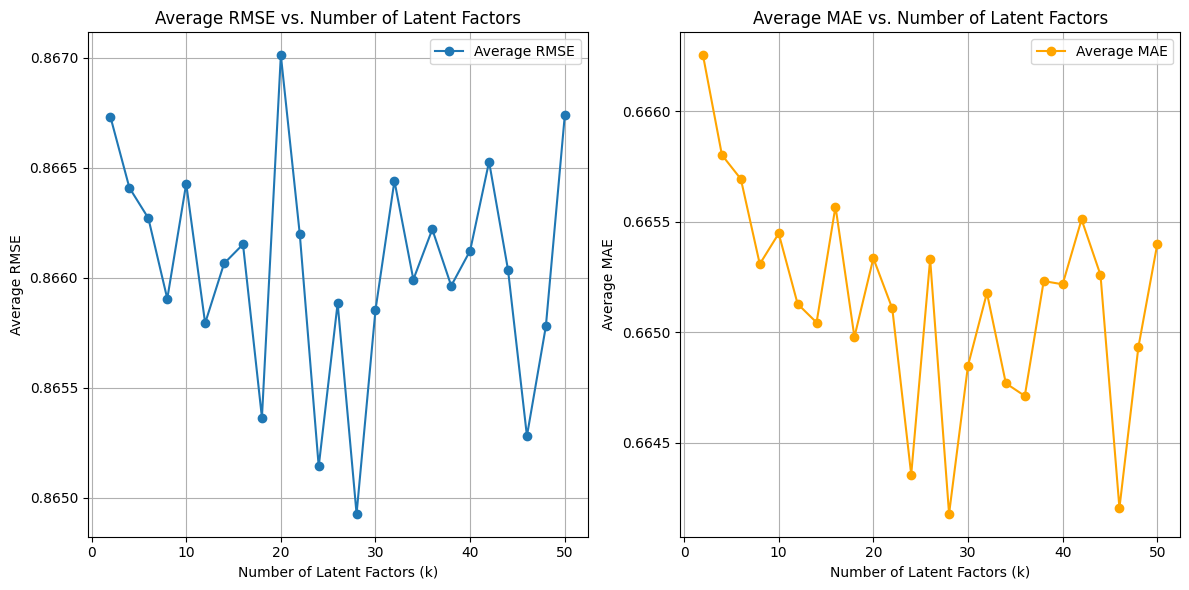

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(k_values, average_rmse, marker='o', label='Average RMSE')
plt.title('Average RMSE vs. Number of Latent Factors')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, average_mae, marker='o', color='orange', label='Average MAE')
plt.title('Average MAE vs. Number of Latent Factors')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
min_avg_rmse = min(average_rmse)
min_k_rmse = k_values[average_rmse.index(min_avg_rmse)]

min_avg_mae = min(average_mae)
min_k_mae = k_values[average_mae.index(min_avg_mae)]

print(f"Minimum Average RMSE: {min_avg_rmse}, at k = {min_k_rmse}")
print(f"Minimum Average MAE: {min_avg_mae}, at k = {min_k_mae}")

Minimum Average RMSE: 0.8649280737069566, at k = 28
Minimum Average MAE: 0.664179490934243, at k = 28


In [ ]:
ratings_popular_movie = ratings_raw[ratings_raw.apply(lambda row: movie_id_counter[row["movieId"]] > 2, axis=1)]
ratings_processed = Dataset.load_from_df(ratings_popular_movie[["userId", "movieId", "rating"]], reader=reader)

k_values = range(2, 51, 2)
average_rmse = []
average_mae = []

for k in k_values:
    algo_popular = SVD(n_factors=k)
    results = cross_validate(algo, ratings_processed, measures=['RMSE', 'MAE'], cv=10, verbose=False)

    average_rmse.append(np.mean(results['test_rmse']))

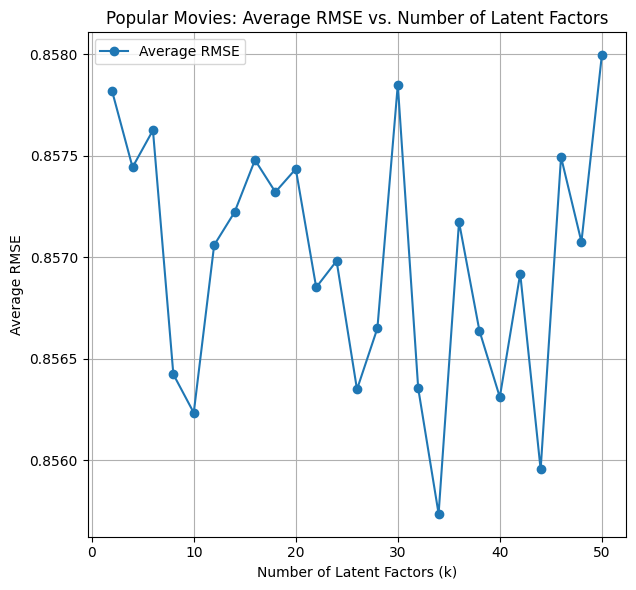

Minimum Average RMSE: 0.8557358259848286, at k = 34


In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(k_values, average_rmse, marker='o', label='Average RMSE')
plt.title('Popular Movies: Average RMSE vs. Number of Latent Factors')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

min_avg_rmse = min(average_rmse)
min_k_rmse = k_values[average_rmse.index(min_avg_rmse)]

print(f"Minimum Average RMSE: {min_avg_rmse}, at k = {min_k_rmse}")


In [ ]:
ratings_unpopular_movie = ratings_raw[ratings_raw.apply(lambda row: movie_id_counter[row["movieId"]] <= 2, axis=1)]
ratings_processed = Dataset.load_from_df(ratings_unpopular_movie[["userId", "movieId", "rating"]], reader=reader)
k_values = range(2, 51, 2)
average_rmse = []
average_mae = []

for k in k_values:
    algo_unpopular = SVD(n_factors=k)
    results = cross_validate(algo, ratings_processed, measures=['RMSE', 'MAE'], cv=10, verbose=False)

    average_rmse.append(np.mean(results['test_rmse']))

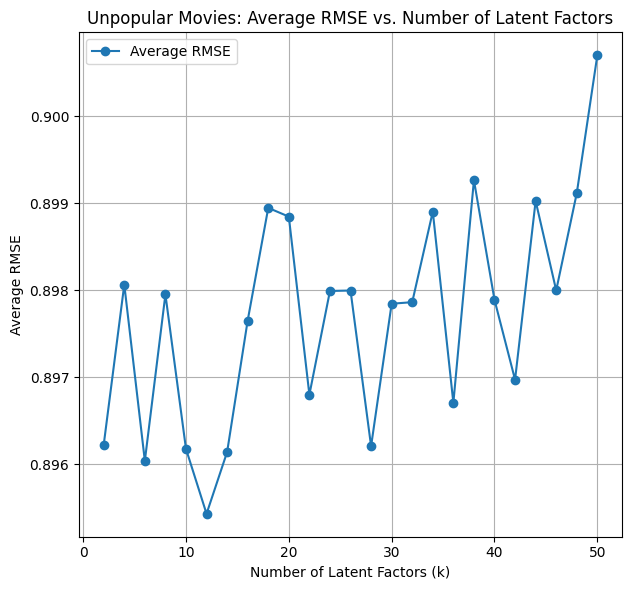

Minimum Average RMSE: 0.8954302497830235, at k = 12


In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(k_values, average_rmse, marker='o', label='Average RMSE')
plt.title('Unpopular Movies: Average RMSE vs. Number of Latent Factors')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

min_avg_rmse = min(average_rmse)
min_k_rmse = k_values[average_rmse.index(min_avg_rmse)]
print(f"Minimum Average RMSE: {min_avg_rmse}, at k = {min_k_rmse}")

In [ ]:
ratings_high_variance_movie = ratings_raw[ratings_raw.apply(lambda row: movie_id_to_variance[row["movieId"]] >= 2 and movie_id_counter[row["movieId"]] >= 5, axis=1)]
ratings_processed = Dataset.load_from_df(ratings_high_variance_movie[["userId", "movieId", "rating"]], reader=reader)
k_values = range(2, 51, 2)
average_rmse = []
average_mae = []

for k in k_values:
    algo_variance = SVD(n_factors=k)
    results = cross_validate(algo, ratings_processed, measures=['RMSE', 'MAE'], cv=10, verbose=False)

    average_rmse.append(np.mean(results['test_rmse']))

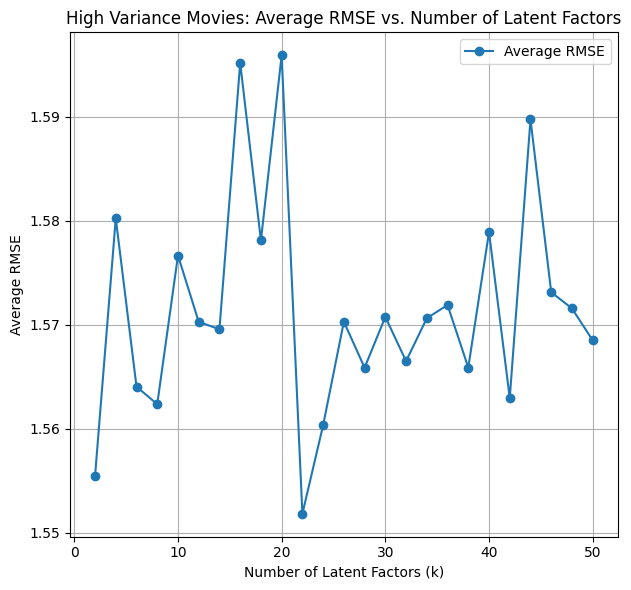

Minimum Average RMSE: 1.5518130198791493, at k = 22


In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(k_values, average_rmse, marker='o', label='Average RMSE')
plt.title('High Variance Movies: Average RMSE vs. Number of Latent Factors')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

min_avg_rmse = min(average_rmse)
min_k_rmse = k_values[average_rmse.index(min_avg_rmse)]
print(f"Minimum Average RMSE: {min_avg_rmse}, at k = {min_k_rmse}")

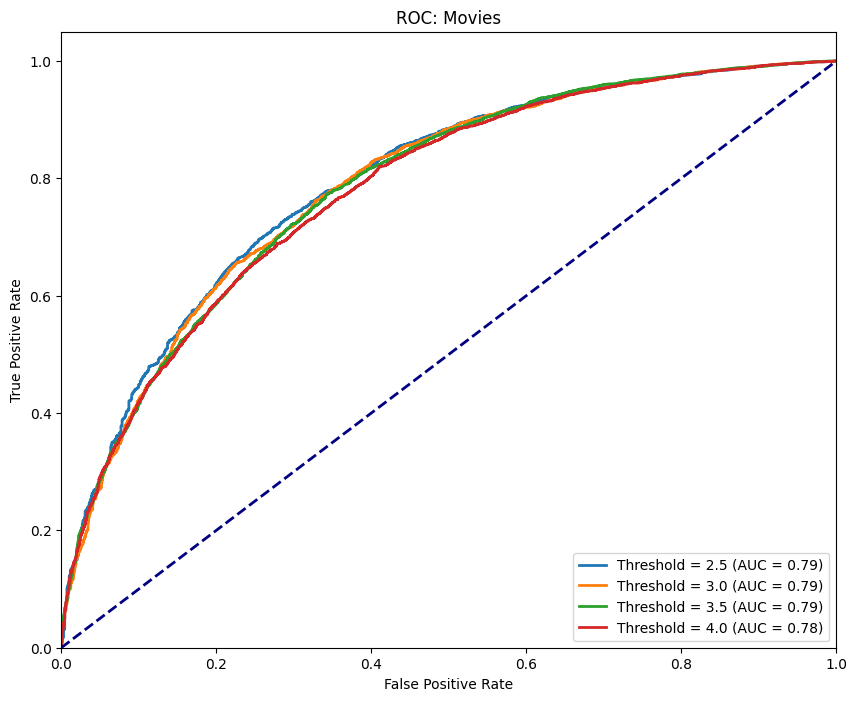

In [ ]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_raw[['userId', 'movieId', 'rating']], reader)

thresholds = [2.5, 3, 3.5, 4]

plt.figure(figsize=(10, 8))

for threshold in thresholds:
    trainset, testset = train_test_split(data, test_size=0.1)
    algo.fit(trainset)
    predictions = algo.test(testset)
    actual = [1 if pred.r_ui >= threshold else 0 for pred in predictions]
    scores = [pred.est for pred in predictions]

    fpr, tpr, _ = roc_curve(actual, scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label='Threshold = %0.1f (AUC = %0.2f)' % (threshold, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Movies')
plt.legend(loc="lower right")
plt.show()


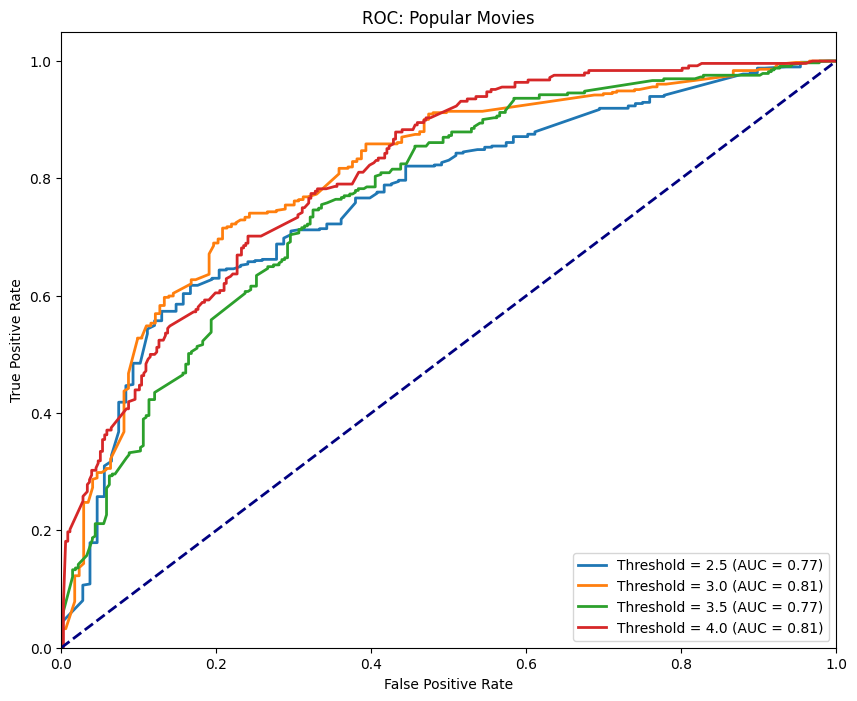

In [ ]:
ratings_popular_movie = ratings_raw[ratings_raw.apply(lambda row: movie_id_counter[row["movieId"]] <= 2, axis=1)]
data = Dataset.load_from_df(ratings_popular_movie[["userId", "movieId", "rating"]], reader=reader)

thresholds = [2.5, 3, 3.5, 4]

plt.figure(figsize=(10, 8))

for threshold in thresholds:
    trainset, testset = train_test_split(data, test_size=0.1)
    algo.fit(trainset)
    predictions = algo.test(testset)
    actual = [1 if pred.r_ui >= threshold else 0 for pred in predictions]
    scores = [pred.est for pred in predictions]

    fpr, tpr, _ = roc_curve(actual, scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label='Threshold = %0.1f (AUC = %0.2f)' % (threshold, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Popular Movies')
plt.legend(loc="lower right")
plt.show()


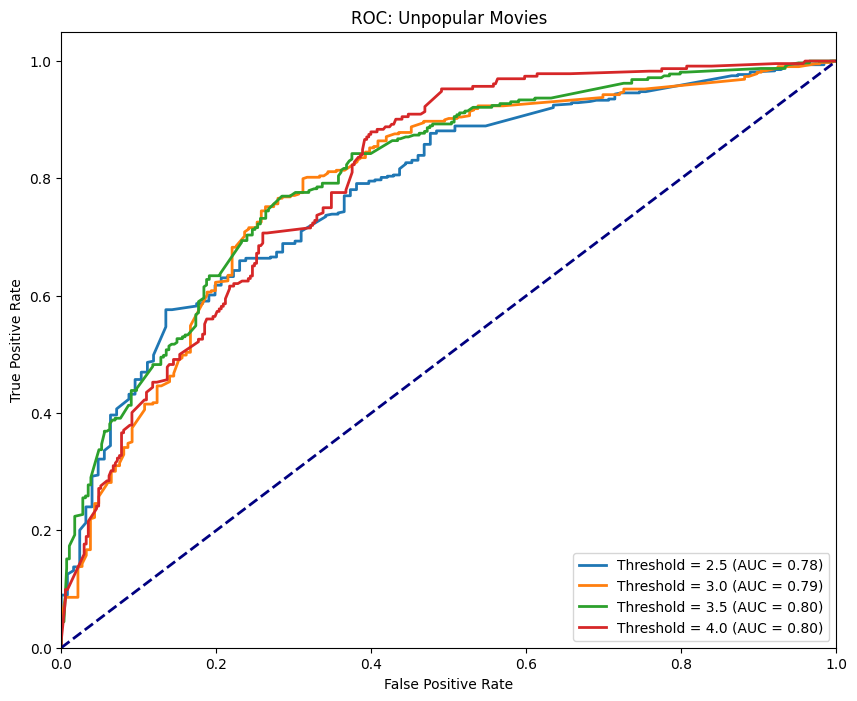

In [ ]:
ratings_unpopular_movie = ratings_raw[ratings_raw.apply(lambda row: movie_id_counter[row["movieId"]] <= 2, axis=1)]
data = Dataset.load_from_df(ratings_unpopular_movie[["userId", "movieId", "rating"]], reader=reader)

thresholds = [2.5, 3, 3.5, 4]

plt.figure(figsize=(10, 8))

for threshold in thresholds:
    trainset, testset = train_test_split(data, test_size=0.1)
    algo.fit(trainset)
    predictions = algo.test(testset)
    actual = [1 if pred.r_ui >= threshold else 0 for pred in predictions]
    scores = [pred.est for pred in predictions]

    fpr, tpr, _ = roc_curve(actual, scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label='Threshold = %0.1f (AUC = %0.2f)' % (threshold, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Unpopular Movies')
plt.legend(loc="lower right")
plt.show()


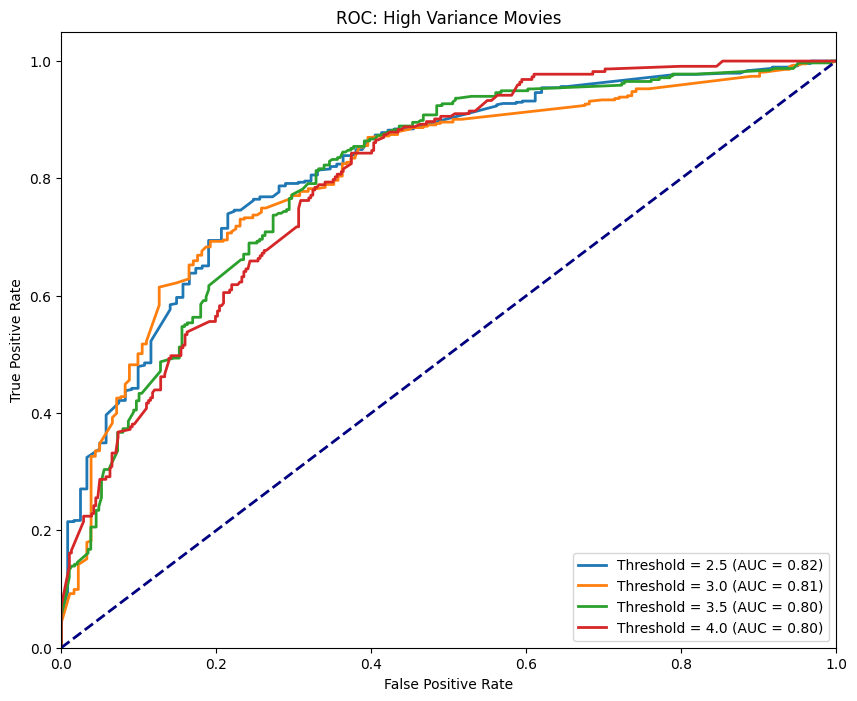

In [ ]:
ratings_high_variance_movie = ratings_raw[ratings_raw.apply(lambda row: movie_id_to_variance[row["movieId"]] >= 2 and movie_id_counter[row["movieId"]] >= 5, axis=1)]
ratings_processed = Dataset.load_from_df(ratings_high_variance_movie[["userId", "movieId", "rating"]], reader=reader)

thresholds = [2.5, 3, 3.5, 4]

plt.figure(figsize=(10, 8))

for threshold in thresholds:
    trainset, testset = train_test_split(data, test_size=0.1)
    algo_variance.fit(trainset)
    predictions = algo_variance.test(testset)
    actual = [1 if pred.r_ui >= threshold else 0 for pred in predictions]
    scores = [pred.est for pred in predictions]

    fpr, tpr, _ = roc_curve(actual, scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label='Threshold = %0.1f (AUC = %0.2f)' % (threshold, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: High Variance Movies')
plt.legend(loc="lower right")
plt.show()


# Naive Collaborative Filter

In [ ]:
from surprise import AlgoBase, Dataset, Reader
from surprise.model_selection import cross_validate
import numpy as np

class NaiveCollaborativeFilter(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        self.global_mean = trainset.global_mean
        self.user_means = {uid: np.mean([r for (_, r) in trainset.ur[uid]]) for uid in trainset.all_users()}

        return self

    def estimate(self, u, i):
        if self.trainset.knows_user(u):
            return self.user_means[u]
        else:
            return self.global_mean

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_raw[['userId', 'movieId', 'rating']], reader)
algo = NaiveCollaborativeFilter()
results = cross_validate(algo, data, measures=['RMSE'], cv=10, verbose=True)
average_rmse = np.mean(results['test_rmse'])
print(f"Average RMSE: {average_rmse}")


Evaluating RMSE of algorithm NaiveCollaborativeFilter on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9381  0.9439  0.9548  0.9329  0.9437  0.9403  0.9387  0.9416  0.9345  0.9429  0.9411  0.0058  
Fit time          0.15    0.13    0.20    0.27    0.34    0.35    0.24    0.21    0.32    0.34    0.25    0.08    
Test time         0.05    0.03    0.05    0.11    0.12    0.10    0.32    0.10    0.08    0.05    0.10    0.08    
Average RMSE: 0.9411424347343129


In [ ]:

ratings_popular_movie = ratings_raw[ratings_raw.apply(lambda row: movie_id_counter[row["movieId"]] <= 2, axis=1)]
ratings_processed = Dataset.load_from_df(ratings_popular_movie[["userId", "movieId", "rating"]], reader=reader)
algo = NaiveCollaborativeFilter()
results = cross_validate(algo, data, measures=['RMSE'], cv=10, verbose=True)
average_rmse = np.mean(results['test_rmse'])
print(f"Average RMSE: {average_rmse}")

ratings_unpopular_movie = ratings_raw[ratings_raw.apply(lambda row: movie_id_counter[row["movieId"]] <= 2, axis=1)]
ratings_processed = Dataset.load_from_df(ratings_unpopular_movie[["userId", "movieId", "rating"]], reader=reader)
algo = NaiveCollaborativeFilter()
results = cross_validate(algo, data, measures=['RMSE'], cv=10, verbose=True)
average_rmse = np.mean(results['test_rmse'])
print(f"Average RMSE: {average_rmse}")

ratings_high_variance_movie = ratings_raw[ratings_raw.apply(lambda row: movie_id_to_variance[row["movieId"]] >= 2 and movie_id_counter[row["movieId"]] >= 5, axis=1)]
ratings_processed = Dataset.load_from_df(ratings_high_variance_movie[["userId", "movieId", "rating"]], reader=reader)
algo = NaiveCollaborativeFilter()
results = cross_validate(algo, data, measures=['RMSE'], cv=10, verbose=True)
average_rmse = np.mean(results['test_rmse'])
print(f"Average RMSE: {average_rmse}")


Evaluating RMSE of algorithm NaiveCollaborativeFilter on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9402  0.9486  0.9467  0.9412  0.9264  0.9264  0.9489  0.9417  0.9579  0.9341  0.9412  0.0095  
Fit time          0.10    0.13    0.13    0.12    0.13    0.13    0.12    0.13    0.13    0.13    0.12    0.01    
Test time         0.23    0.03    0.03    0.03    0.22    0.03    0.03    0.03    0.23    0.03    0.09    0.09    
Average RMSE: 0.941208142060875
Evaluating RMSE of algorithm NaiveCollaborativeFilter on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9389  0.9382  0.9512  0.9407  0.9310  0.9483  0.9445  0.9371  0.9404  0.9384  0.9409  0.0055  
Fit time          0.08    0.13    0.13    0.12    0.13    0.14    0.13    0.17    0.17    0.18    0.14    0.03    
Test time         0.0

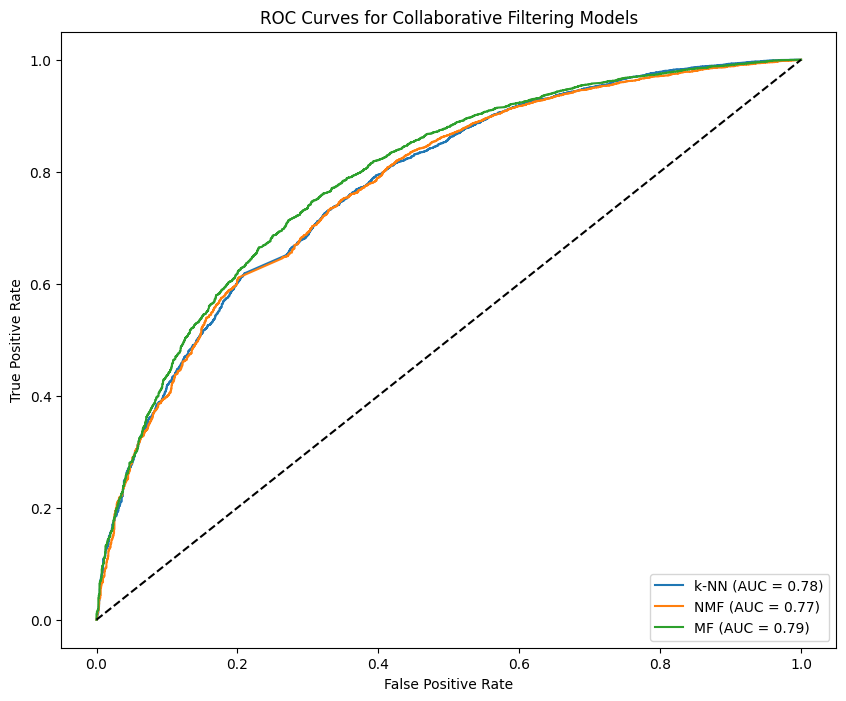

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from surprise import Dataset, Reader, KNNWithMeans, NMF, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_raw[['userId', 'movieId', 'rating']], reader)

threshold = 3

plt.figure(figsize=(10, 8))

algorithms = {
    "k-NN": KNNWithMeans(k=20, sim_options={"name": "pearson"}, verbose=False),
    "NMF": NMF(n_factors=18, n_epochs=50, verbose=False),
    "MF": algo
}

for name, algorithm in algorithms.items():
    trainset, testset = train_test_split(data, test_size=0.1)
    algorithm.fit(trainset)
    predictions = algorithm.test(testset)
    actual = [1 if pred.r_ui >= threshold else 0 for pred in predictions]
    scores = [pred.est for pred in predictions]

    fpr, tpr, _ = roc_curve(actual, scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Collaborative Filtering Models')
plt.legend(loc="lower right")
plt.show()


In [4]:
!pip install lightgbm

# Ranking

In [6]:
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import ndcg_score
import numpy as np

def load_one_fole(data_path):
    X_train, y_train, qid_train = load_svmlight_file(str(data_path + 'train.txt'), query_id=True)
    X_test, y_test, qid_test = load_svmlight_file(str(data_path + 'test.txt'), query_id=True)
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    _, group_train = np.unique(qid_train, return_counts=True)
    _, group_test = np.unique(qid_test, return_counts=True)
    return X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test

def ndcg_single_query(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def compute_ndcg_all(model, X_test, y_test, qids_test, k=10):
    unique_qids = np.unique(qids_test)
    ndcg_ = list()
    for i, qid in enumerate(unique_qids):
        y = y_test[qids_test == qid]

        if np.sum(y) == 0:
            continue

        p = model.predict(X_test[qids_test == qid])

        idcg = ndcg_single_query(y, y, k=k)
        ndcg_.append(ndcg_single_query(p, y, k=k) / idcg)
    return np.mean(ndcg_)

def get_feature_importance(model, importance_type='gain'):
    booster = model if isinstance(model, lgb.Booster) else model.booster_
    feature_importance = booster.feature_importance(importance_type=importance_type)
    return feature_importance

In [7]:
data_paths = ['MSLR-WEB10K/Fold1/','MSLR-WEB10K/Fold2/','MSLR-WEB10K/Fold3/','MSLR-WEB10K/Fold4/', 'MSLR-WEB10K/Fold5/']

data_mapping = {}

for data_path in data_paths:
    X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test = load_one_fole(data_path)

    unique_queries_train = np.unique(qid_train)
    unique_queries_test = np.unique(qid_test)
    print(f"Number of unique queries in training data: {len(unique_queries_train)}")
    print(f"Number of unique queries in testing data: {len(unique_queries_test)}")

    def show_label_distribution(labels):
        unique, counts = np.unique(labels, return_counts=True)
        distribution = dict(zip(unique, counts))
        return distribution

    print(data_path + ": distribution of relevance labels in training data:", show_label_distribution(y_train))
    print(data_path + ": distribution of relevance labels in testing data:", show_label_distribution(y_test))

    data_mapping[data_path] = {
        'X_train': X_train,
        'y_train': y_train,
        'qid_train': qid_train,
        'group_train': group_train,
        'X_test': X_test,
        'y_test': y_test,
        'qid_test': qid_test,
        'group_test': group_test
    }


Number of unique queries in training data: 6000
Number of unique queries in testing data: 2000
MSLR-WEB10K/Fold1/: distribution of relevance labels in training data: {0: 377957, 1: 232569, 2: 95082, 3: 12658, 4: 5146}
MSLR-WEB10K/Fold1/: distribution of relevance labels in testing data: {0: 124784, 1: 77896, 2: 32459, 3: 4450, 4: 1932}
Number of unique queries in training data: 6000
Number of unique queries in testing data: 2000
MSLR-WEB10K/Fold2/: distribution of relevance labels in training data: {0: 373029, 1: 230368, 2: 95117, 3: 12814, 4: 5355}
MSLR-WEB10K/Fold2/: distribution of relevance labels in testing data: {0: 126450, 1: 78016, 2: 31875, 3: 4053, 4: 1594}
Number of unique queries in training data: 6000
Number of unique queries in testing data: 2000
MSLR-WEB10K/Fold3/: distribution of relevance labels in training data: {0: 371725, 1: 232302, 2: 96663, 3: 12903, 4: 5518}
MSLR-WEB10K/Fold3/: distribution of relevance labels in testing data: {0: 126088, 1: 75962, 2: 30913, 3: 4

In [13]:
import lightgbm as lgb
import numpy as np


def train_and_evaluate(data_mapping):
    ndcg_scores = {fold: {'nDCG@3': None, 'nDCG@5': None, 'nDCG@10': None} for fold in data_mapping.keys()}

    for fold, data in data_mapping.items():
        train_data = lgb.Dataset(data['X_train'], label=data['y_train'], group=data['group_train'])
        test_data = lgb.Dataset(data['X_test'], label=data['y_test'], group=data['group_test'], reference=train_data)

        params = {
            'objective': 'lambdarank',
            'metric': 'ndcg',
            'ndcg_eval_at': [3, 5, 10],
            'learning_rate': 0.05,
            'num_leaves': 31,
            'verbose': -1
        }

        bst = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])

        for k in [3, 5, 10]:
            ndcg_score = compute_ndcg_all(bst, data['X_test'], data['y_test'], data['qid_test'], k=k)
            ndcg_scores[fold][f'nDCG@{k}'] = ndcg_score

        print(f"Fold: {fold}")
        for k, score in ndcg_scores[fold].items():
            print(f" {k}: {score}")

    return ndcg_scores

ndcg_scores_all_folds = train_and_evaluate(data_mapping)


Fold: MSLR-WEB10K/Fold1/
 nDCG@3: 0.4507545733421516
 nDCG@5: 0.4578584529635828
 nDCG@10: 0.47526631675350844
Fold: MSLR-WEB10K/Fold2/
 nDCG@3: 0.4553792656858033
 nDCG@5: 0.45858527312708586
 nDCG@10: 0.47448031694933906
Fold: MSLR-WEB10K/Fold3/
 nDCG@3: 0.44264358098686574
 nDCG@5: 0.45089828268619103
 nDCG@10: 0.46929926593829596
Fold: MSLR-WEB10K/Fold4/
 nDCG@3: 0.4537689345392404
 nDCG@5: 0.46129047048566274
 nDCG@10: 0.48107878993967995
Fold: MSLR-WEB10K/Fold5/
 nDCG@3: 0.4602039959641346
 nDCG@5: 0.46494845249290095
 nDCG@10: 0.4838716356178689


In [17]:
def train_evaluate_extract_features(data_mapping):
    for fold, data in data_mapping.items():
        print(f"Processing {fold}")

        train_data = lgb.Dataset(data['X_train'], label=data['y_train'], group=data['group_train'])
        test_data = lgb.Dataset(data['X_test'], label=data['y_test'], group=data['group_test'], reference=train_data)
        params = {
            'objective': 'lambdarank',
            'metric': 'ndcg',
            'ndcg_eval_at': [3, 5, 10],
            'learning_rate': 0.05,
            'num_leaves': 31,
            'verbose': -1
        }
        bst = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])

        importance = get_feature_importance(bst, importance_type='gain')

        top_features_indices = np.argsort(importance)[::-1][:5]
        top_features_scores = importance[top_features_indices]

        print(f"Top 5 features for {fold}:")
        for i, (index, score) in enumerate(zip(top_features_indices, top_features_scores), start=1):
            print(f" {i}. Feature {index} with importance score {score}")

train_evaluate_extract_features(data_mapping)

Processing MSLR-WEB10K/Fold1/
Top 5 features for MSLR-WEB10K/Fold1/:
 1. Feature 133 with importance score 50900.37763404846
 2. Feature 7 with importance score 10627.043670654297
 3. Feature 54 with importance score 7749.175968170166
 4. Feature 107 with importance score 6956.837522506714
 5. Feature 129 with importance score 6634.954565525055
Processing MSLR-WEB10K/Fold2/
Top 5 features for MSLR-WEB10K/Fold2/:
 1. Feature 133 with importance score 50648.40989303589
 2. Feature 107 with importance score 11437.986242294312
 3. Feature 54 with importance score 8245.528983592987
 4. Feature 129 with importance score 7510.931382656097
 5. Feature 7 with importance score 6916.260050296783
Processing MSLR-WEB10K/Fold3/
Top 5 features for MSLR-WEB10K/Fold3/:
 1. Feature 133 with importance score 50574.326808452606
 2. Feature 54 with importance score 11866.20094537735
 3. Feature 107 with importance score 9030.951606750488
 4. Feature 129 with importance score 7123.230594158173
 5. Feature 1

In [9]:
import numpy as np
import lightgbm as lgb

def train_evaluate_with_feature_removal_and_save(data_mapping):
    models_and_data = {}

    for fold, data in data_mapping.items():
        print(f"Processing {fold}")

        train_data = lgb.Dataset(data['X_train'], label=data['y_train'], group=data['group_train'])
        test_data = lgb.Dataset(data['X_test'], label=data['y_test'], group=data['group_test'], reference=train_data)
        params = {
            'objective': 'lambdarank',
            'metric': 'ndcg',
            'ndcg_eval_at': [3, 5, 10],
            'learning_rate': 0.05,
            'num_leaves': 31,
            'verbose': -1
        }
        bst_initial = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])

        importance = get_feature_importance(bst_initial, 'gain')
        top_features_indices = np.argsort(importance)[::-1][:20]

        X_train_reduced = np.delete(data['X_train'].toarray(), top_features_indices, axis=1)
        X_test_reduced = np.delete(data['X_test'].toarray(), top_features_indices, axis=1)

        train_data_reduced = lgb.Dataset(X_train_reduced, label=data['y_train'], group=data['group_train'])
        test_data_reduced = lgb.Dataset(X_test_reduced, label=data['y_test'], group=data['group_test'], reference=train_data_reduced)
        bst_reduced = lgb.train(params, train_data_reduced, num_boost_round=100, valid_sets=[test_data_reduced])

        ndcg_scores = {}
        for k in [3, 5, 10]:
            ndcg_score = compute_ndcg_all(bst_reduced, X_test_reduced, data['y_test'], data['qid_test'], k=k)
            ndcg_scores[f"nDCG@{k}"] = ndcg_score
            print(f"Results after removing top 20 features for {fold}, nDCG@{k}: {ndcg_score}")

        models_and_data[fold] = {
            'bst': bst_initial,
        }

    return models_and_data

models_and_data = train_evaluate_with_feature_removal_and_save(data_mapping)

Processing MSLR-WEB10K/Fold1/
Results after removing top 20 features for MSLR-WEB10K/Fold1/, nDCG@3: 0.37665442320354864
Results after removing top 20 features for MSLR-WEB10K/Fold1/, nDCG@5: 0.38413822877401
Results after removing top 20 features for MSLR-WEB10K/Fold1/, nDCG@10: 0.4071277032381892
Processing MSLR-WEB10K/Fold2/
Results after removing top 20 features for MSLR-WEB10K/Fold2/, nDCG@3: 0.3746364353293466
Results after removing top 20 features for MSLR-WEB10K/Fold2/, nDCG@5: 0.3824200534838482
Results after removing top 20 features for MSLR-WEB10K/Fold2/, nDCG@10: 0.40465018340842035
Processing MSLR-WEB10K/Fold3/
Results after removing top 20 features for MSLR-WEB10K/Fold3/, nDCG@3: 0.38564342488744446
Results after removing top 20 features for MSLR-WEB10K/Fold3/, nDCG@5: 0.39209358541294026
Results after removing top 20 features for MSLR-WEB10K/Fold3/, nDCG@10: 0.414126048617549
Processing MSLR-WEB10K/Fold4/
Results after removing top 20 features for MSLR-WEB10K/Fold4/, nDC

In [11]:
def train_evaluate_with_least_important_features_removed(data_mapping, models_and_data):
    for fold, data in data_mapping.items():
        print(f"Processing {fold}")

        train_data = lgb.Dataset(data['X_train'], label=data['y_train'], group=data['group_train'])
        test_data = lgb.Dataset(data['X_test'], label=data['y_test'], group=data['group_test'], reference=train_data)
        params = {
            'objective': 'lambdarank',
            'metric': 'ndcg',
            'ndcg_eval_at': [3, 5, 10],
            'learning_rate': 0.05,
            'num_leaves': 31,
            'verbose': -1
        }
        bst = models_and_data[fold]['bst']

        importance = get_feature_importance(bst, 'gain')
        least_important_features_indices = np.argsort(importance)[:60]

        X_train_reduced = np.delete(data['X_train'].toarray(), least_important_features_indices, axis=1)
        X_test_reduced = np.delete(data['X_test'].toarray(), least_important_features_indices, axis=1)

        train_data_reduced = lgb.Dataset(X_train_reduced, label=data['y_train'], group=data['group_train'])
        test_data_reduced = lgb.Dataset(X_test_reduced, label=data['y_test'], group=data['group_test'], reference=train_data_reduced)
        bst_reduced = lgb.train(params, train_data_reduced, num_boost_round=100, valid_sets=[test_data_reduced])

        print(f"Results after removing 60 least important features for {fold}:")
        for k in [3, 5, 10]:
            ndcg_score = compute_ndcg_all(bst_reduced, X_test_reduced, data['y_test'], data['qid_test'], k=k)
            print(f" nDCG@{k}: {ndcg_score}")

train_evaluate_with_least_important_features_removed(data_mapping, models_and_data)


Processing MSLR-WEB10K/Fold1/
Results after removing 60 least important features for MSLR-WEB10K/Fold1/:
 nDCG@3: 0.4515562386034378
 nDCG@5: 0.45916313597340386
 nDCG@10: 0.4771597716694684
Processing MSLR-WEB10K/Fold2/
Results after removing 60 least important features for MSLR-WEB10K/Fold2/:
 nDCG@3: 0.4529432831508957
 nDCG@5: 0.45679748885924365
 nDCG@10: 0.47255906199425574
Processing MSLR-WEB10K/Fold3/
Results after removing 60 least important features for MSLR-WEB10K/Fold3/:
 nDCG@3: 0.4414064368308733
 nDCG@5: 0.45034963186744653
 nDCG@10: 0.469722748845401
Processing MSLR-WEB10K/Fold4/
Results after removing 60 least important features for MSLR-WEB10K/Fold4/:
 nDCG@3: 0.45213119122423573
 nDCG@5: 0.46009315884010593
 nDCG@10: 0.47995869215501286
Processing MSLR-WEB10K/Fold5/
Results after removing 60 least important features for MSLR-WEB10K/Fold5/:
 nDCG@3: 0.45836563346727144
 nDCG@5: 0.46594720737839157
 nDCG@10: 0.48467115112574144
